# Reconstrucción del campo de flujo en una cavidad cuadrada
## TP N°4: Resolución del problema inverso
### Redes Neuronales Informadas por Física - Maestria en Inteligencia Artificial
#### Grupo N°4: Jorge Ceferino Valdez, Fabian Sarmiento y Trinidad Monreal.
---

Buscamos reconstruir el campo de flujo estacionario en una cavidad cuadrada usando una Red Neuronal Informada por Física (PINN). Se trata de resolver las ecuaciones de Navier-Stokes incomprensibles:

$$(\mathbf{u} \cdot \nabla)\mathbf{u} = -\nabla p + \frac{1}{Re} \nabla^2 \mathbf{u} \text{,  en Ω}$$

$$\nabla \cdot \mathbf{u} = 0 \text{,  en Ω}$$

con las siguientes condiciones de borde:

- _No-slip_ en las fronteras laterales e inferior ($\mathbf{u} = (0,0)$)
- Velocidad constante en direccion $+x$ en la frontera superior ($\mathbf{u} = (1,0)$)

y $Ω = [0,1]⊗[0,1]$

In [1]:
import os
import torch
import torch.nn as nn
import torch.nn.init as init
from torch.utils.data import Dataset, DataLoader, TensorDataset, ConcatDataset

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import cm
import seaborn as sns
from mpl_toolkits.mplot3d import axes3d
from scipy.io import loadmat
from scipy.interpolate import griddata

from IPython.display import clear_output
import time
from datetime import datetime, timedelta
import gc
from tqdm import trange

np.random.seed(42)

if torch.cuda.is_available():
    device = torch.device("cuda:0")
    device_name = "CUDA GPU"
elif torch.backends.mps.is_available():
    device = torch.device("mps")
    device_name = "Apple Silicon GPU (MPS)"
else:
    device = torch.device("cpu")
    device_name = "CPU"

# Configurar semillas para reproducibilidad
torch.manual_seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed(42)
elif torch.backends.mps.is_available():
    # MPS usa la misma semilla que PyTorch general
    torch.manual_seed(42)

print(f"Usando dispositivo: {device} ({device_name})")

Usando dispositivo: cuda:0 (CUDA GPU)


In [2]:
# Crear un directorio para guardar las gráficas
graficas_dir = os.path.join("graficas", "tp4")

if not os.path.exists(graficas_dir):
    os.makedirs(graficas_dir)

### Clase PINN Navier-stokes

In [3]:
class PINN_Module(nn.Module):
    """
    Red Neuronal Informada por Física para resolver las ecuaciones de Navier-Stokes
    en una cavidad cuadrada con lid-driven flow.
    Modelo modificado.
    Usa re-parametrización de Re (Número de Reynolds) para mejorar la convergencia.
    """

    def __init__(self, model_parameters):
        super(PINN_Module, self).__init__()
        self.Device = model_parameters["Device"]
        self.LowerBounds = model_parameters["LowerBounds"]
        self.UpperBounds = model_parameters["UpperBounds"]
        self.InputDimensions = model_parameters["InputDimensions"]
        self.OutputDimensions = model_parameters["OutputDimensions"]
        self.NumberOfNeurons = model_parameters["NumberOfNeurons"]
        self.NumberOfHiddenLayers = model_parameters["NumberOfHiddenLayers"]
        self.ActivationFunction = model_parameters["ActivationFunction"]

        # Número de Reynolds: entrenable o fijo
        if model_parameters.get("LearnRe", False):
            # Aprendemos log(Re) en lugar de Re para estabilizar el gradiente
            initial_re = model_parameters["Re"]
            # Guardamos el parámetro entrenable como self.log_Re
            self.log_Re = nn.Parameter(torch.tensor([np.log(initial_re)], dtype=torch.float32, device=self.Device))
        else:
            # Si no aprendemos Re, guardamos el valor fijo
            self.fixed_Re = torch.tensor([model_parameters["Re"]], dtype=torch.float32, device=self.Device)


        # Definir arquitectura de la red
        self.InputLayer = nn.Linear(self.InputDimensions, self.NumberOfNeurons)
        self.HiddenLayers = nn.ModuleList(
            [nn.Linear(self.NumberOfNeurons, self.NumberOfNeurons)
             for _ in range(self.NumberOfHiddenLayers - 1)])
        self.OutputLayer = nn.Linear(self.NumberOfNeurons, self.OutputDimensions)

        # Inicialización Xavier
        self.init_xavier()

    def get_re(self):
        """
        Devuelve el valor actual de Re.
        Si Re es entrenable, calcula exp(log(Re)).
        Si es fijo, devuelve el valor fijo.
        """
        if hasattr(self, 'log_Re'):
            return torch.exp(self.log_Re)
        else:
            return self.fixed_Re

    def forward(self, X):
        """
        Forward pass de la red neuronal
        Input: X tensor de forma (N, 2) con coordenadas (x, y)
        Output: tensor de forma (N, 3) con (u, v, p)
        """
        lb = self.LowerBounds
        ub = self.UpperBounds

        # Normalización de entradas a [-1, 1]
        X = 2 * (X - lb) / (ub - lb) - 1

        # Forward pass
        output = self.ActivationFunction(self.InputLayer(X))
        for k, l in enumerate(self.HiddenLayers):
            output = self.ActivationFunction(l(output))
        output = self.OutputLayer(output)

        return output

    def predict(self, X):
        """
        Predicción directa de u, v, p a partir de coordenadas (x, y).
        """
        uvp = self.forward(X)
        u = uvp[:, 0:1]
        v = uvp[:, 1:2]
        p = uvp[:, 2:3]
        return u, v, p

    def init_xavier(self):
        """Inicialización Xavier mejorada de los pesos"""
        def init_weights(m):
            if type(m) == nn.Linear and m.weight.requires_grad and m.bias.requires_grad:
                g = nn.init.calculate_gain('tanh')
                torch.nn.init.xavier_uniform_(m.weight, gain=g)
                # Bias no cero para romper simetría
                torch.nn.init.uniform_(m.bias, -0.1, 0.1)

        self.apply(init_weights)

    def navierstokesResidue(self, X, uvp):
        """
        Calcula los residuos de las ecuaciones de Navier-Stokes

        Ecuaciones:
        (u·∇)u = -∇p + (1/Re)∇²u  →  u*∂u/∂x + v*∂u/∂y + ∂p/∂x - (1/Re)(∂²u/∂x² + ∂²u/∂y²) = 0
        (u·∇)v = -∇p + (1/Re)∇²v  →  u*∂v/∂x + v*∂v/∂y + ∂p/∂y - (1/Re)(∂²v/∂x² + ∂²v/∂y²) = 0
        ∇·u = ∂u/∂x + ∂v/∂y = 0
        """
        u = uvp[:, 0:1]  # velocidad en x
        v = uvp[:, 1:2]  # velocidad en y
        p = uvp[:, 2:3]  # presión

        # Obtenemos Re usando el nuevo método
        Re = self.get_re()

        # Derivadas de primer orden usando autodiferenciación
        diff_u = torch.autograd.grad(u, X, create_graph=True, grad_outputs=torch.ones_like(u))[0]
        u_x = diff_u[:, 0:1]
        u_y = diff_u[:, 1:2]

        diff_v = torch.autograd.grad(v, X, create_graph=True, grad_outputs=torch.ones_like(v))[0]
        v_x = diff_v[:, 0:1]
        v_y = diff_v[:, 1:2]

        diff_p = torch.autograd.grad(p, X, create_graph=True, grad_outputs=torch.ones_like(p))[0]
        p_x = diff_p[:, 0:1]
        p_y = diff_p[:, 1:2]

        # Derivadas de segundo orden
        u_xx = torch.autograd.grad(u_x, X, create_graph=True, grad_outputs=torch.ones_like(u_x))[0][:, 0:1]
        u_yy = torch.autograd.grad(u_y, X, create_graph=True, grad_outputs=torch.ones_like(u_y))[0][:, 1:2]

        v_xx = torch.autograd.grad(v_x, X, create_graph=True, grad_outputs=torch.ones_like(v_x))[0][:, 0:1]
        v_yy = torch.autograd.grad(v_y, X, create_graph=True, grad_outputs=torch.ones_like(v_y))[0][:, 1:2]

        # Residuos de las ecuaciones de momentum
        residue_u = u * u_x + v * u_y + p_x - (1/Re) * (u_xx + u_yy)
        residue_v = u * v_x + v * v_y + p_y - (1/Re) * (v_xx + v_yy)

        # Residuo de continuidad
        residue_continuity = u_x + v_y

        return residue_u, residue_v, residue_continuity

    def compute_residual_norm(self, X):
        uvp = self.forward(X)
        r_u, r_v, _ = self.navierstokesResidue(X, uvp)
        residual_norm = (r_u ** 2 + r_v ** 2).squeeze()
        return residual_norm

#### Configuración del dominio y condiciones de borde

In [4]:
# Parámetros del problema
xi, xf = 0.0, 1.0  # Límites en x
yi, yf = 0.0, 1.0  # Límites en y

# Límites del dominio
lb = torch.tensor([xi, yi], device=device)  # Lower bounds
ub = torch.tensor([xf, yf], device=device)  # Upper bounds

# Condiciones de borde
u_wall = 0.0    # Velocidad en las paredes (no-slip)
v_wall = 0.0    # Velocidad normal en las paredes
u_lid = 1.0     # Velocidad de la tapa superior
v_lid = 0.0     # Velocidad normal en la tapa

print(f"Dominio: [{xi}, {xf}] x [{yi}, {yf}]")
print(f"Condiciones de borde:")
print(f"  - Paredes laterales e inferior: u=v=0 (no-slip)")
print(f"  - Tapa superior: u={u_lid}, v={v_lid}")

Dominio: [0.0, 1.0] x [0.0, 1.0]
Condiciones de borde:
  - Paredes laterales e inferior: u=v=0 (no-slip)
  - Tapa superior: u=1.0, v=0.0


#### Carga de datos de ground-truth

In [5]:
# Cargar datos de los .mat
pressure_mat = loadmat('Re-100/pressure.mat')
velocity_mat = loadmat('Re-100/velocity.mat')

x = pressure_mat['x'].squeeze()
y = pressure_mat['y'].squeeze()
p = pressure_mat['p'].squeeze()
u = velocity_mat['u'].squeeze()
v = velocity_mat['v'].squeeze()

# Reconstruir grilla regular
x_unique = np.linspace(x.min(), x.max(), 201)
y_unique = np.linspace(y.min(), y.max(), 201)
X_grid, Y_grid = np.meshgrid(x_unique, y_unique)

# Interpolar campos sobre la grilla
U_grid = griddata((x, y), u, (X_grid, Y_grid), method='cubic')
V_grid = griddata((x, y), v, (X_grid, Y_grid), method='cubic')
P_grid = griddata((x, y), p, (X_grid, Y_grid), method='cubic')

# Preparar puntos para evaluación del modelo
X_eval = torch.tensor(np.stack([X_grid.flatten(), Y_grid.flatten()], axis=1), dtype=torch.float32, device=device)

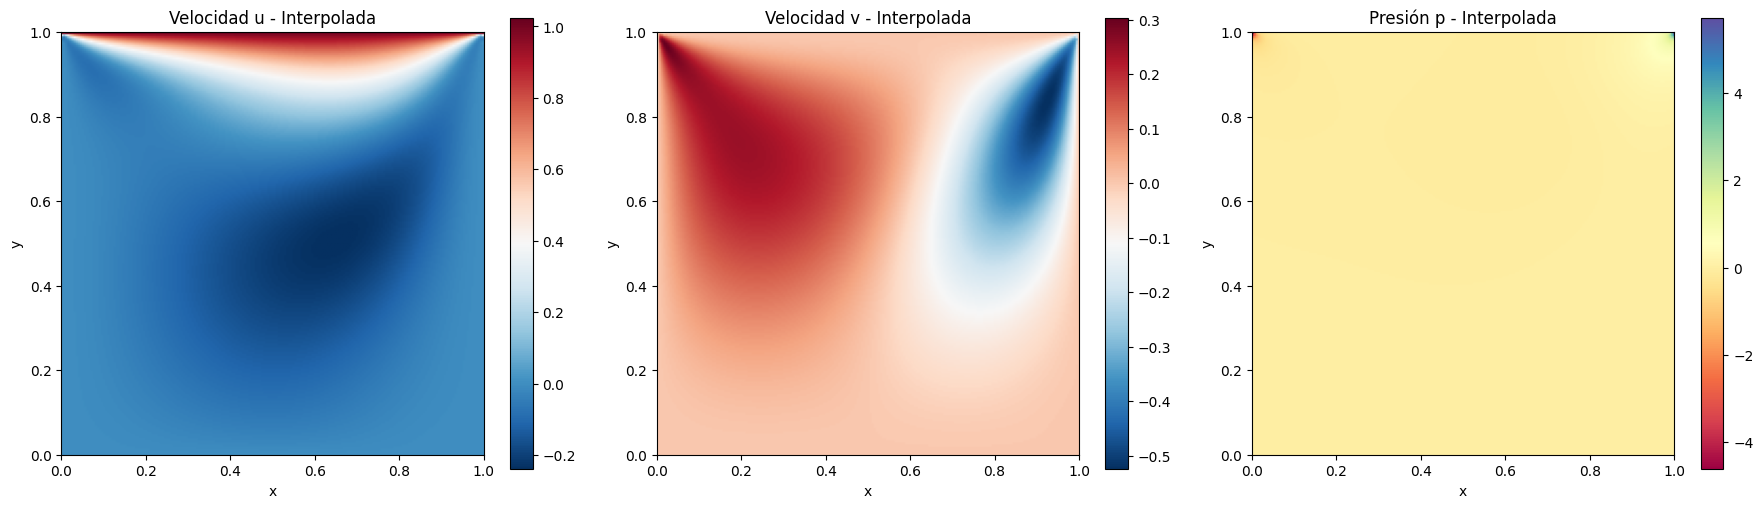

In [6]:
fig, axs = plt.subplots(1, 3, figsize=(18, 5))

# Campo u
im0 = axs[0].imshow(U_grid, extent=[x.min(), x.max(), y.min(), y.max()],
                    origin='lower', cmap='RdBu_r', aspect='equal')
axs[0].set_title("Velocidad u - Interpolada")
axs[0].set_xlabel("x")
axs[0].set_ylabel("y")
plt.colorbar(im0, ax=axs[0])

# Campo v
im1 = axs[1].imshow(V_grid, extent=[x.min(), x.max(), y.min(), y.max()],
                    origin='lower', cmap='RdBu_r', aspect='equal')
axs[1].set_title("Velocidad v - Interpolada")
axs[1].set_xlabel("x")
axs[1].set_ylabel("y")
plt.colorbar(im1, ax=axs[1])

# Campo p
im2 = axs[2].imshow(P_grid, extent=[x.min(), x.max(), y.min(), y.max()],
                    origin='lower', cmap='Spectral', aspect='equal')
axs[2].set_title("Presión p - Interpolada")
axs[2].set_xlabel("x")
axs[2].set_ylabel("y")
plt.colorbar(im2, ax=axs[2])

plt.tight_layout()
plt.show()

#### Muestreo por Hipercubo Latino (LHS)

In [7]:
def lhs_1d(N, device):
    """
    Realiza muestreo por hipercubo latino en 1D.
    Divide el intervalo [0,1] en N subintervalos y toma un punto aleatorio en cada uno,
    luego los mezcla aleatoriamente.
    """
    intervals = torch.linspace(0, 1, N + 1, device=device)
    lower_bounds = intervals[:-1]
    upper_bounds = intervals[1:]
    points = lower_bounds + (upper_bounds - lower_bounds) * torch.rand(N, device=device)
    return points[torch.randperm(N)]

def latin_hypercube_sampling(N_pde, N_bc, device):
    """
    Genera puntos de colocación para PINNs usando muestreo por hipercubo latino (LHS).
    - Puntos interiores (PDE)
    - Puntos de borde (BC): bottom, top, left, right
    """
    x_pde = lhs_1d(N_pde, device)
    y_pde = lhs_1d(N_pde, device)
    pde_points = torch.stack([x_pde, y_pde], dim=1)

    N_each = N_bc // 4
    rand = lhs_1d(N_each, device)

    bottom = torch.stack([rand, torch.zeros_like(rand)], dim=1)
    top    = torch.stack([rand, torch.ones_like(rand)], dim=1)
    left   = torch.stack([torch.zeros_like(rand), rand], dim=1)
    right  = torch.stack([torch.ones_like(rand), rand], dim=1)

    bc_points = torch.cat([bottom, top, left, right], dim=0)

    return pde_points, bottom, top, left, right, bc_points

### 1. Construir tres datasets con $N_{data}$ = 25 a partir de los datos ground-truth del problema.

_Para ello, extraerán los valores de 𝒖 y 𝑝 de grillas regulares cuadradas de 5×5. La región cuadrada en la que se inscriben tales grillas debe estar centrada en Ω y con sus aristas paralelas a las de la cavidad, y con los siguientes tamaños:_
- a) 0,25 × 0,25,
- b) 0,50 × 0,50,
- c) 0,75 × 0,75.

In [8]:
def get_labeled_data(center=(0.5, 0.5), size=0.25, grid_resolution=5):
    """
    Extrae una grilla cuadrada de puntos (x,y) en el dominio, centrada en `center` y con lado `size`.
    Interpola u, v, p desde los campos ground-truth.

    Devuelve:
    - coords_tensor: tensor (25,2) de coordenadas (x,y)
    - labels_tensor: tensor (25,3) de [u, v, p]
    """
    x0, y0 = center
    half = size / 2
    xs = np.linspace(x0 - half, x0 + half, grid_resolution)
    ys = np.linspace(y0 - half, y0 + half, grid_resolution)
    XX, YY = np.meshgrid(xs, ys)
    coords = np.stack([XX.ravel(), YY.ravel()], axis=1)

    # Interpolación desde las grillas
    u_vals = griddata((X_grid.ravel(), Y_grid.ravel()), U_grid.ravel(), coords, method='cubic')
    v_vals = griddata((X_grid.ravel(), Y_grid.ravel()), V_grid.ravel(), coords, method='cubic')
    p_vals = griddata((X_grid.ravel(), Y_grid.ravel()), P_grid.ravel(), coords, method='cubic')

    # Convertir a tensores
    coords_tensor = torch.tensor(coords, dtype=torch.float32, device=device)
    labels_tensor = torch.tensor(np.stack([u_vals, v_vals, p_vals], axis=1), dtype=torch.float32, device=device)

    return coords_tensor, labels_tensor

In [9]:
def plot_labeled_datasets(coords_list, labels_list, sizes):
    """
    Crea 4 subplots:
    - uno para cada grilla (0.25, 0.5, 0.75)
    - uno con los tres combinados como el gráfico original
    """
    colors = ['red', 'green', 'blue']
    _, axs = plt.subplots(2, 2, figsize=(12, 12))
    axs = axs.flatten()

    for i, (coords, labels, size) in enumerate(zip(coords_list, labels_list, sizes)):
        coords_np = coords.detach().cpu().numpy()
        u_np = labels[:, 0].detach().cpu().numpy()
        v_np = labels[:, 1].detach().cpu().numpy()

        axs[i].quiver(coords_np[:, 0], coords_np[:, 1], u_np, v_np,
                      angles='xy', scale_units='xy', scale=5, color=colors[i])
        axs[i].scatter(coords_np[:, 0], coords_np[:, 1], s=20, color=colors[i])
        axs[i].set_title(f"Grilla {size}×{size}")
        axs[i].set_xlim(0, 1)
        axs[i].set_ylim(0, 1)
        axs[i].grid(True)
        axs[i].set_aspect('equal')
        axs[i].set_xlabel("x")
        axs[i].set_ylabel("y")

    # Último subplot: todos juntos
    for i, (coords, labels, size) in enumerate(zip(coords_list, labels_list, sizes)):
        coords_np = coords.detach().cpu().numpy()
        u_np = labels[:, 0].detach().cpu().numpy()
        v_np = labels[:, 1].detach().cpu().numpy()
        axs[3].quiver(coords_np[:, 0], coords_np[:, 1], u_np, v_np,
                      angles='xy', scale_units='xy', scale=5, color=colors[i], label=f"{size}×{size}")
        axs[3].scatter(coords_np[:, 0], coords_np[:, 1], s=10, color=colors[i])

    axs[3].set_title("Todas las grillas superpuestas")
    axs[3].legend(loc='lower right')
    axs[3].set_xlim(0, 1)
    axs[3].set_ylim(0, 1)
    axs[3].grid(True)
    axs[3].set_aspect('equal')
    axs[3].set_xlabel("x")
    axs[3].set_ylabel("y")

    plt.tight_layout()
    plt.show()

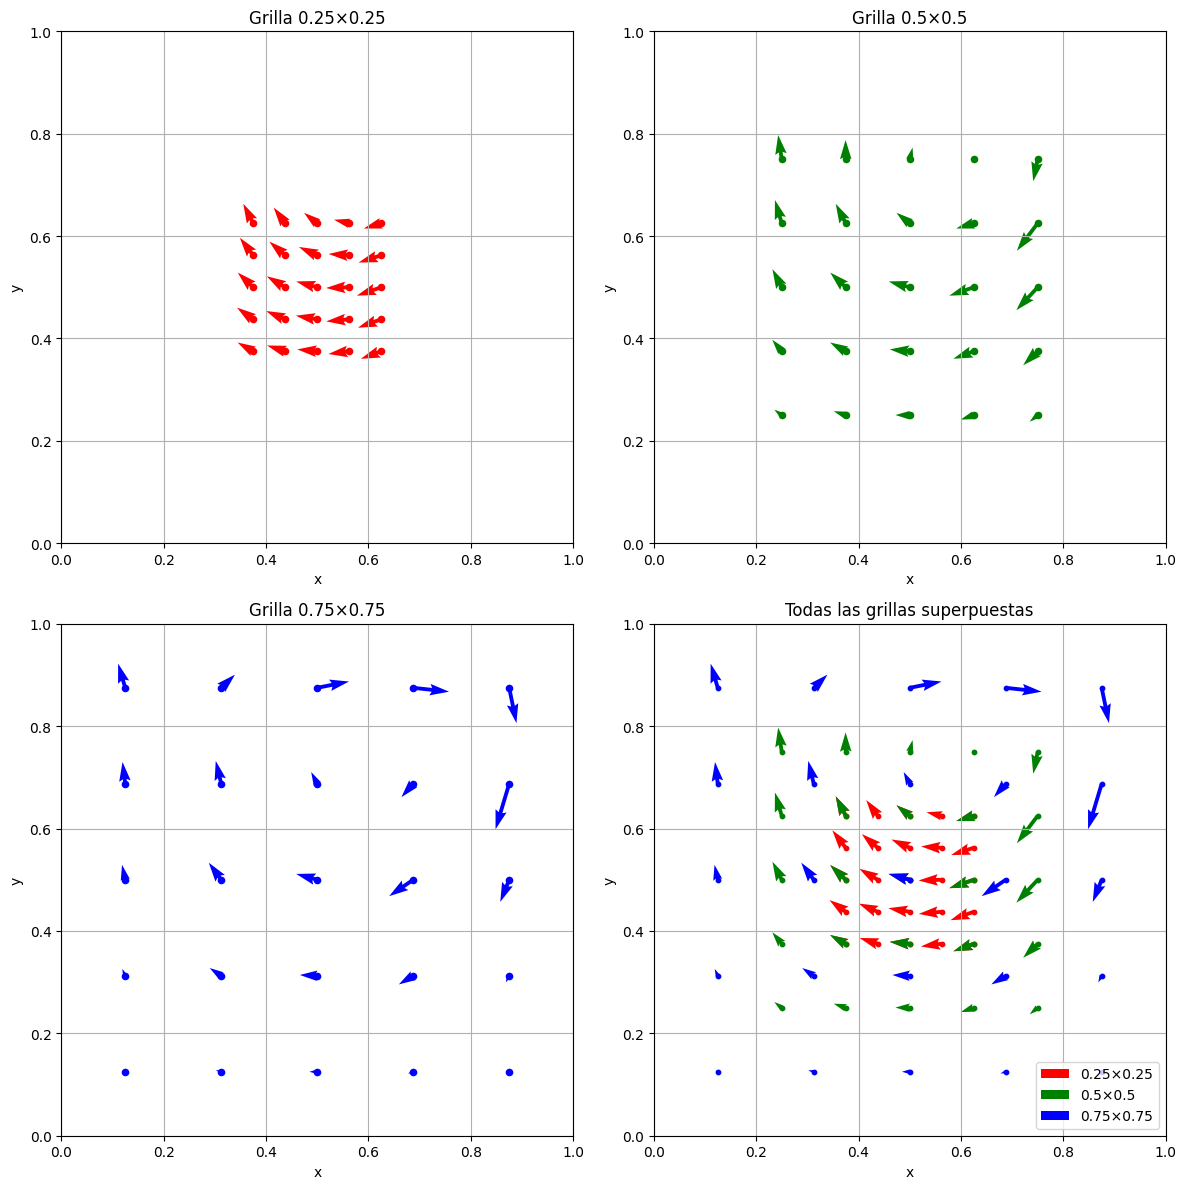

In [10]:
coords_025, labels_025 = get_labeled_data(size=0.25)
coords_050, labels_050 = get_labeled_data(size=0.50)
coords_075, labels_075 = get_labeled_data(size=0.75)

plot_labeled_datasets(coords_list=[coords_025, coords_050, coords_075],labels_list=[labels_025, labels_050, labels_075],sizes=[0.25, 0.50, 0.75])

### 2. En cada grilla, considerar el caso de datos “limpios” (es decir, sin ruido), y afectados por ruido blanco, con un nivel de 0.01 % del valor máximo del campo correspondiente en la región considerada.

In [11]:
def add_white_noise(labels_tensor, noise_level=0.0001):
    """
    Agrega ruido blanco a cada componente del tensor (u, v, p)
    El ruido es proporcional al valor máximo absoluto de cada componente
    """
    noisy = []
    for i in range(labels_tensor.shape[1]):  # u, v, p
        max_val = torch.max(torch.abs(labels_tensor[:, i]))
        noise = noise_level * max_val * torch.randn_like(labels_tensor[:, i])
        noisy.append(labels_tensor[:, i] + noise)
    return torch.stack(noisy, dim=1)

In [12]:
labels_025_noisy = add_white_noise(labels_025)
labels_050_noisy = add_white_noise(labels_050)
labels_075_noisy = add_white_noise(labels_075)

### 3. Obtener el valor del número de Reynolds para cada configuración.

_Los datasets de puntos de colocación deberán ser construidos mediante la estrategia LHS, con N_pde = 10000, N_bc = 1000._

In [13]:
N_pde = 10000
N_bc = 1000
pde_points, bottom, top, left, right, bc_points = latin_hypercube_sampling(N_pde, N_bc, device)

#### Configuración del modelo

In [14]:
# Parámetros del modelo: mantenemos igual a TP2
model_parameters = {
    "Device": device,
    "LowerBounds": lb.to(device),
    "UpperBounds": ub.to(device),
    "Re": 50.0,  # valor inicial, incorrecto a propósito
    "LearnRe": True,
    "InputDimensions": 2,      # (x, y)
    "OutputDimensions": 3,     # (u, v, p)
    "NumberOfNeurons": 48,    # Era 200 - REDUCIDO por CPU
    "NumberOfHiddenLayers": 6, # Era 12 - REDUCIDO por CPU
    "ActivationFunction": nn.GELU()
}

In [15]:
# Crear modelo
torch.manual_seed(10)
model = PINN_Module(model_parameters).to(device)

print("Arquitectura del modelo:")
print(f"  - Entradas: {model_parameters['InputDimensions']} (x, y)")
print(f"  - Salidas: {model_parameters['OutputDimensions']} (u, v, p)")
print(f"  - Capas ocultas: {model_parameters['NumberOfHiddenLayers']}")
print(f"  - Neuronas por capa: {model_parameters['NumberOfNeurons']}")
print(f"  - Función de activación: {model_parameters['ActivationFunction']}")

# Contar parámetros
total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"  - Total de parámetros entrenables: {total_params}")

Arquitectura del modelo:
  - Entradas: 2 (x, y)
  - Salidas: 3 (u, v, p)
  - Capas ocultas: 6
  - Neuronas por capa: 48
  - Función de activación: GELU(approximate='none')
  - Total de parámetros entrenables: 12052


### Entrenamiento

In [16]:
def compute_bc_loss(uvp, u_target, v_target, loss_fn):
    loss_u = loss_fn(uvp[:, 0:1], u_target)
    loss_v = loss_fn(uvp[:, 1:2], v_target)
    return loss_u + loss_v

# Función para calcular pérdida de presión de referencia
def compute_pressure_reference_loss(model, loss_fn):
    """
    Calcula la pérdida para forzar que p(0,0) = 0
    Esto elimina la indeterminación de la constante en el campo de presión
    """
    # Punto de referencia (0,0)
    reference_point = torch.tensor([[0.0, 0.0]], device=device, requires_grad=True)

    # Evaluar el modelo en el punto de referencia
    uvp_ref = model(reference_point)
    p_ref = uvp_ref[:, 2:3]  # Extraer presión

    # La presión en (0,0) debe ser cero
    target_pressure = torch.zeros_like(p_ref)

    return loss_fn(p_ref, target_pressure)

# Función de entrenamiento
def train_pinn(model, pde_points, top, bottom, left, right,
               epochs, optimizer, scheduler,
               weight_pde, lambda_bc, weight_pressure_ref,
               coords_labeled=None, labels_labeled=None, weight_labeled=1.0,
               weight_re_reg=0.01,  # Este es un nuevo hiperparámetro para regularización de Re
               strategy=None, Npde=None, Nbc=None,
               loss_fn=nn.MSELoss()):
    """
    Entrena un modelo PINN para el problema de la cavidad cuadrada.
    Guarda el modelo con nombre basado en la estrategia y el tamaño del dataset.
    """
    # Historial de pérdidas
    loss_train = []
    loss_train_momentum_u = []
    loss_train_momentum_v = []
    loss_train_continuity = []
    loss_train_bc = []
    loss_train_pressure_ref = []
    loss_train_labeled = []
    loss_train_re_reg = [] # Agregamos al historial el historial de regularización de Re

    # Usar un valor fijo es a menudo más estable.
    re_anchor_value = 100.0 

    print("Iniciando entrenamiento ...")
    t0 = datetime.now()

    for epoch in trange(epochs, desc="Entrenando modelo PINN"):
        model.train()
        optimizer.zero_grad()

        # === PDE ===
        pde_points_epoch = pde_points.detach().clone().requires_grad_(True)
        uvp_pde = model(pde_points_epoch)
        res_u, res_v, res_cont = model.navierstokesResidue(pde_points_epoch, uvp_pde)

        # Pérdidas PDE
        loss_u = loss_fn(res_u, torch.zeros_like(res_u))
        loss_v = loss_fn(res_v, torch.zeros_like(res_v))
        loss_cont = loss_fn(res_cont, torch.zeros_like(res_cont))
        # Datos rotulados (opcional)
        if coords_labeled is not None and labels_labeled is not None:
            model_output_labeled = model(coords_labeled)
            loss_labeled = loss_fn(model_output_labeled[:, :3], labels_labeled)

        else:
            loss_labeled = torch.tensor(0.0, device=device)
        loss_pde_total = loss_u + loss_v + loss_cont

        # === Regularización de Re ===
        current_re = model.get_re()
        # Penalizamos la diferencia cuadrática con el valor de anclaje
        loss_re_reg = (current_re - re_anchor_value)**2

        # === BC ===
        uvp_top = model(top)
        uvp_bottom = model(bottom)
        uvp_left = model(left)
        uvp_right = model(right)

        loss_bc_top = compute_bc_loss(uvp_top,
                                      torch.ones_like(uvp_top[:, 0:1]),
                                      torch.zeros_like(uvp_top[:, 1:2]),
                                      loss_fn)
        loss_bc_bottom = compute_bc_loss(uvp_bottom,
                                         torch.zeros_like(uvp_bottom[:, 0:1]),
                                         torch.zeros_like(uvp_bottom[:, 1:2]),
                                         loss_fn)
        loss_bc_left = compute_bc_loss(uvp_left,
                                       torch.zeros_like(uvp_left[:, 0:1]),
                                       torch.zeros_like(uvp_left[:, 1:2]),
                                       loss_fn)
        loss_bc_right = compute_bc_loss(uvp_right,
                                        torch.zeros_like(uvp_right[:, 0:1]),
                                        torch.zeros_like(uvp_right[:, 1:2]),
                                        loss_fn)
        loss_bc_total = loss_bc_top + loss_bc_bottom + loss_bc_left + loss_bc_right

        # === Presión de referencia ===
        loss_pressure_ref = compute_pressure_reference_loss(model, loss_fn)

        # === Pérdida total ===
        loss_total = (weight_pde * loss_pde_total +
                      lambda_bc * loss_bc_total +
                      weight_pressure_ref * loss_pressure_ref+
                      weight_labeled * loss_labeled +
                      weight_re_reg * loss_re_reg) # Agregamos la nueva pérdida

        loss_total.backward()
        optimizer.step()
        scheduler.step()

        # Guardar pérdidas
        loss_train.append(loss_total.item())
        loss_train_momentum_u.append(loss_u.item())
        loss_train_momentum_v.append(loss_v.item())
        loss_train_continuity.append(loss_cont.item())
        loss_train_bc.append(loss_bc_total.item())
        loss_train_pressure_ref.append(loss_pressure_ref.item())
        loss_train_labeled.append(loss_labeled.item())
        loss_train_re_reg.append(loss_re_reg.item())  # Guardamos la pérdida de regularización de Re

        # Logs
        if epoch % 500 == 0 or epoch == epochs - 1:
            model.eval()
            with torch.no_grad():
                u_top_mean = model(top)[:, 0].mean().item()
                ref_point = torch.tensor([[0.0, 0.0]], device=model.Device)
                p_ref_value = model(ref_point)[0, 2].item()
                #estimated_Re = model.Re.item() if isinstance(model.Re, torch.nn.Parameter) else model.Re
                estimated_Re = model.get_re().item() # Re-parametrización, más estable


            print(f"Epoch {epoch:4d} | Total: {loss_total.item():.2e} | PDE: {loss_pde_total.item():.2e} | "
                  f"BC: {loss_bc_total.item():.2e} | P_ref: {loss_pressure_ref.item():.2e} | "
                  f"p(0,0): {p_ref_value:.4f} | u_top: {u_top_mean:.3f} | Re: {estimated_Re:.2f}")


    #final_Re = model.Re.item() if isinstance(model.Re, torch.nn.Parameter) else model.Re
    final_Re = model.get_re().item()
    print(f"\nValor final estimado de Re: {final_Re:.4f}")

    elapsed = datetime.now() - t0
    print(f"\nTiempo total: {elapsed.total_seconds():.1f} segundos")

    # Guardar modelo con nombre descriptivo
    models_dir = "models"
    if not os.path.exists(models_dir):
        os.makedirs(models_dir)

    time_str = datetime.now().strftime('%Y%m%d_%H%M%S')
    filename = f"pinn_{strategy}_Npde{Npde}_Nbc{Nbc}_{time_str}.pt" if strategy and Npde and Nbc else f"pinn_trained_{time_str}.pt"
    torch.save(model.state_dict(), os.path.join(models_dir, filename))
    print(f"Modelo guardado como: models/{filename}")

    return {
        "total": loss_train,
        "u_momentum": loss_train_momentum_u,
        "v_momentum": loss_train_momentum_v,
        "continuity": loss_train_continuity,
        "bc": loss_train_bc,
        "pressure_ref": loss_train_pressure_ref,
        "labeled": loss_train_labeled,
        "re_reg": loss_train_re_reg  # Nueva pérdida de regularización de Re
    }

#### Gráficos de evolución de pérdidas

In [17]:
# Función para graficar pérdidas con nueva pérdida
def plot_losses(loss_dict, strategy, Npde, Nbc):
    loss_list = [
        loss_dict["total"],
        loss_dict["u_momentum"],
        loss_dict["v_momentum"],
        loss_dict["continuity"],
        loss_dict["bc"],
        loss_dict["pressure_ref"],
        loss_dict["labeled"]
    ]
    colors = ['black', 'red', 'green', 'blue', 'magenta', 'orange', 'gray']
    titles = ['Overall Loss', 'Momentum U', 'Momentum V', 'Continuity', 'BC', 'Pressure Ref', 'Labeled Data']

    _, ax = plt.subplots(1, len(loss_list), figsize=(25, 4))
    for i, loss in enumerate(loss_list):
        ax[i].loglog(np.arange(len(loss)), loss, color=colors[i])
        ax[i].set_xlabel("Epoch")
        ax[i].set_title(titles[i])
        ax[i].grid(True)
    plt.tight_layout()
    # Guardar la figura en el directorio graficas con nombre descriptivo
    plt.savefig(f"{graficas_dir}/perdidas_{strategy}_Npde{Npde}_Nbc{Nbc}.png")
    plt.show()

In [18]:
def plot_comparacion_uvp(u_pred, v_pred, p_pred, strategy, Npde, Nbc,
                          U_grid, V_grid, P_grid, x, y):
    """
    Plotea comparación de u, v, p entre solución de referencia (MEF) y predicción (PINN),
    incluyendo errores absolutos.

    Parámetros:
    - u_pred, v_pred, p_pred: resultados del modelo PINN (2D arrays)
    - strategy: nombre de la estrategia ('uniform', 'lhs', 'rad')
    - Npde, Nbc: tamaños del dataset
    - U_grid, V_grid, P_grid: campos de referencia (MEF)
    - x, y: arrays con coordenadas para los ejes
    """
    fig, axs = plt.subplots(3, 3, figsize=(18, 13))

    # Extensión para todas las gráficas
    extent = [x.min(), x.max(), y.min(), y.max()]

    # --- Velocidad u ---
    im0 = axs[0, 0].imshow(U_grid, extent=extent,
                           origin='lower', cmap='RdBu_r', aspect='equal')
    axs[0, 0].set_title(r"$u_{MEF}$")
    axs[0, 0].set_ylabel("y")
    plt.colorbar(im0, ax=axs[0, 0])

    # PREDICCIÓN PINN u - ESCALA SINCRONIZADA
    im1 = axs[0, 1].imshow(u_pred, extent=extent,
                           origin='lower', cmap='RdBu_r', aspect='equal',
                           vmin=U_grid.min(), vmax=U_grid.max())  # ← SINCRONIZACIÓN
    axs[0, 1].set_title(r"$u_{PINN}$")
    plt.colorbar(im1, ax=axs[0, 1])

    im2 = axs[0, 2].imshow(np.abs(u_pred - U_grid), extent=extent,
                           origin='lower', cmap='Reds', aspect='equal')
    axs[0, 2].set_title(r"$|u_{PINN} - u_{MEF}|$")
    plt.colorbar(im2, ax=axs[0, 2])

    # --- Velocidad v ---
    im3 = axs[1, 0].imshow(V_grid, extent=extent,
                           origin='lower', cmap='RdBu_r', aspect='equal')
    axs[1, 0].set_title(r"$v_{MEF}$")
    axs[1, 0].set_ylabel("y")
    plt.colorbar(im3, ax=axs[1, 0])

    # PREDICCIÓN PINN v - ESCALA SINCRONIZADA
    im4 = axs[1, 1].imshow(v_pred, extent=extent,
                           origin='lower', cmap='RdBu_r', aspect='equal',
                           vmin=V_grid.min(), vmax=V_grid.max())  # ← SINCRONIZACIÓN
    axs[1, 1].set_title(r"$v_{PINN}$")
    plt.colorbar(im4, ax=axs[1, 1])

    im5 = axs[1, 2].imshow(np.abs(v_pred - V_grid), extent=extent,
                           origin='lower', cmap='Reds', aspect='equal')
    axs[1, 2].set_title(r"$|v_{PINN} - v_{MEF}|$")
    plt.colorbar(im5, ax=axs[1, 2])

    # --- Presión p ---
    im6 = axs[2, 0].imshow(P_grid, extent=extent,
                           origin='lower', cmap='Spectral', aspect='equal')
    axs[2, 0].set_title(r"$p_{MEF}$")
    axs[2, 0].set_ylabel("y")
    axs[2, 0].set_xlabel("x")
    plt.colorbar(im6, ax=axs[2, 0])

    # PREDICCIÓN PINN p - ESCALA SINCRONIZADA
    im7 = axs[2, 1].imshow(p_pred, extent=extent,
                           origin='lower', cmap='Spectral', aspect='equal',
                           vmin=P_grid.min(), vmax=P_grid.max())  # ← SINCRONIZACIÓN
    axs[2, 1].set_title(r"$p_{PINN}$")
    axs[2, 1].set_xlabel("x")
    plt.colorbar(im7, ax=axs[2, 1])

    im8 = axs[2, 2].imshow(np.abs(p_pred - P_grid), extent=extent,
                           origin='lower', cmap='Reds', aspect='equal')
    axs[2, 2].set_title(r"$|p_{PINN} - p_{MEF}|$")
    axs[2, 2].set_xlabel("x")
    plt.colorbar(im8, ax=axs[2, 2])

    plt.suptitle(f"Comparación de campos: {strategy.upper()} - Npde={Npde}, Nbc={Nbc}",
                 fontsize=16)
    plt.tight_layout(rect=[0, 0, 1, 0.97])  # espacio para el título
    # Guardoramos la figura en el directorio graficas con nombre descriptivo
    if strategy is None or Npde is None or Nbc is None:
        plt.savefig(f"{graficas_dir}/comparacion_uvp_trained_model.png")
    else:
        # Guardamos con nombre descriptivo
        plt.savefig(f"{graficas_dir}/comparacion_uvp_{strategy}_Npde{Npde}_Nbc{Nbc}.png")

    plt.show()

In [19]:
def plot_perfiles_lineas_caracteristicas(u_pred, v_pred, p_pred,
                                         U_grid, V_grid, P_grid,
                                         X_grid, Y_grid, strategy, Npde, Nbc):
    """
    Grafica perfiles verticales y horizontales de u, v y p en x=0.5 y y=0.5.
    Compara predicción PINN con la referencia.
    """
    x_center_idx = X_grid.shape[1] // 2
    y_center_idx = Y_grid.shape[0] // 2

    x_line = X_grid[0, :]
    y_line = Y_grid[:, 0]

    fig, axs = plt.subplots(2, 3, figsize=(18, 10))

    # --- Verticales en x = 0.5 ---
    axs[0, 0].plot(U_grid[:, x_center_idx], y_line, 'b-', label='Referencia')
    axs[0, 0].plot(u_pred[:, x_center_idx], y_line, 'r--', label='PINN')
    axs[0, 0].set_title('u en x=0.5')
    axs[0, 0].set_xlabel('u'); axs[0, 0].set_ylabel('y'); axs[0, 0].grid(True)

    axs[0, 1].plot(V_grid[:, x_center_idx], y_line, 'b-')
    axs[0, 1].plot(v_pred[:, x_center_idx], y_line, 'r--')
    axs[0, 1].set_title('v en x=0.5')
    axs[0, 1].set_xlabel('v'); axs[0, 1].set_ylabel('y'); axs[0, 1].grid(True)

    axs[0, 2].plot(P_grid[:, x_center_idx], y_line, 'b-')
    axs[0, 2].plot(p_pred[:, x_center_idx], y_line, 'r--')
    axs[0, 2].set_title('p en x=0.5')
    axs[0, 2].set_xlabel('p'); axs[0, 2].set_ylabel('y'); axs[0, 2].grid(True)

    # --- Horizontales en y = 0.5 ---
    axs[1, 0].plot(x_line, U_grid[y_center_idx, :], 'b-')
    axs[1, 0].plot(x_line, u_pred[y_center_idx, :], 'r--')
    axs[1, 0].set_title('u en y=0.5')
    axs[1, 0].set_ylabel('u'); axs[1, 0].set_xlabel('x'); axs[1, 0].grid(True)

    axs[1, 1].plot(x_line, V_grid[y_center_idx, :], 'b-')
    axs[1, 1].plot(x_line, v_pred[y_center_idx, :], 'r--')
    axs[1, 1].set_title('v en y=0.5')
    axs[1, 1].set_ylabel('v'); axs[1, 1].set_xlabel('x'); axs[1, 1].grid(True)

    axs[1, 2].plot(x_line, P_grid[y_center_idx, :], 'b-')
    axs[1, 2].plot(x_line, p_pred[y_center_idx, :], 'r--')
    axs[1, 2].set_title('p en y=0.5')
    axs[1, 2].set_ylabel('p'); axs[1, 2].set_xlabel('x'); axs[1, 2].grid(True)

    for ax in axs.flat:
        ax.legend()

    plt.tight_layout()
    name = f"{graficas_dir}/perfiles_{strategy}_Npde{Npde}_Nbc{Nbc}.png"
    plt.savefig(name)
    plt.show()


=== Entrenando modelo: 025_clean ===
Iniciando entrenamiento ...


Entrenando modelo PINN:   0%|          | 1/10000 [00:00<22:45,  7.32it/s]

Epoch    0 | Total: 1.75e+01 | PDE: 4.13e-01 | BC: 8.96e-01 | P_ref: 2.25e-02 | p(0,0): 0.2358 | u_top: 0.243 | Re: 50.09


Entrenando modelo PINN:   5%|▌         | 508/10000 [00:10<03:14, 48.84it/s]

Epoch  500 | Total: 2.94e-01 | PDE: 4.32e-02 | BC: 2.22e-02 | P_ref: 3.56e-07 | p(0,0): 0.0008 | u_top: 0.977 | Re: 94.95


Entrenando modelo PINN:  10%|█         | 1008/10000 [00:21<03:04, 48.62it/s]

Epoch 1000 | Total: 1.67e-01 | PDE: 2.62e-02 | BC: 1.40e-02 | P_ref: 9.89e-07 | p(0,0): -0.0009 | u_top: 0.990 | Re: 100.09


Entrenando modelo PINN:  15%|█▌        | 1509/10000 [00:31<02:53, 48.86it/s]

Epoch 1500 | Total: 1.33e-01 | PDE: 1.93e-02 | BC: 1.13e-02 | P_ref: 7.98e-07 | p(0,0): -0.0006 | u_top: 0.989 | Re: 100.11


Entrenando modelo PINN:  20%|██        | 2009/10000 [00:41<02:50, 47.00it/s]

Epoch 2000 | Total: 1.16e-01 | PDE: 1.53e-02 | BC: 1.00e-02 | P_ref: 8.73e-08 | p(0,0): 0.0006 | u_top: 0.974 | Re: 100.10


Entrenando modelo PINN:  25%|██▌       | 2508/10000 [00:52<02:36, 47.98it/s]

Epoch 2500 | Total: 9.86e-02 | PDE: 1.12e-02 | BC: 8.71e-03 | P_ref: 6.68e-07 | p(0,0): 0.0001 | u_top: 0.986 | Re: 100.09


Entrenando modelo PINN:  30%|███       | 3007/10000 [01:02<02:22, 49.10it/s]

Epoch 3000 | Total: 8.92e-02 | PDE: 8.76e-03 | BC: 8.03e-03 | P_ref: 8.48e-07 | p(0,0): -0.0010 | u_top: 0.996 | Re: 100.07


Entrenando modelo PINN:  35%|███▌      | 3508/10000 [01:13<02:10, 49.59it/s]

Epoch 3500 | Total: 8.09e-02 | PDE: 7.42e-03 | BC: 7.33e-03 | P_ref: 5.77e-07 | p(0,0): -0.0011 | u_top: 0.995 | Re: 100.06


Entrenando modelo PINN:  40%|████      | 4006/10000 [01:23<02:00, 49.62it/s]

Epoch 4000 | Total: 7.60e-02 | PDE: 6.82e-03 | BC: 6.91e-03 | P_ref: 5.48e-07 | p(0,0): -0.0002 | u_top: 0.999 | Re: 100.05


Entrenando modelo PINN:  45%|████▌     | 4510/10000 [01:33<01:50, 49.78it/s]

Epoch 4500 | Total: 7.08e-02 | PDE: 6.13e-03 | BC: 6.46e-03 | P_ref: 1.99e-09 | p(0,0): -0.0003 | u_top: 0.997 | Re: 100.04


Entrenando modelo PINN:  50%|█████     | 5007/10000 [01:43<01:43, 48.17it/s]

Epoch 5000 | Total: 6.70e-02 | PDE: 5.80e-03 | BC: 6.11e-03 | P_ref: 3.44e-09 | p(0,0): -0.0001 | u_top: 0.990 | Re: 100.04


Entrenando modelo PINN:  55%|█████▌    | 5507/10000 [01:53<01:31, 48.95it/s]

Epoch 5500 | Total: 6.45e-02 | PDE: 5.46e-03 | BC: 5.90e-03 | P_ref: 2.34e-08 | p(0,0): -0.0003 | u_top: 0.998 | Re: 100.03


Entrenando modelo PINN:  60%|██████    | 6006/10000 [02:03<01:21, 49.12it/s]

Epoch 6000 | Total: 6.25e-02 | PDE: 5.56e-03 | BC: 5.69e-03 | P_ref: 4.23e-08 | p(0,0): -0.0002 | u_top: 0.988 | Re: 100.03


Entrenando modelo PINN:  65%|██████▌   | 6508/10000 [02:14<01:10, 49.22it/s]

Epoch 6500 | Total: 5.99e-02 | PDE: 5.20e-03 | BC: 5.46e-03 | P_ref: 9.78e-08 | p(0,0): -0.0003 | u_top: 0.995 | Re: 100.03


Entrenando modelo PINN:  70%|███████   | 7011/10000 [02:24<00:59, 50.00it/s]

Epoch 7000 | Total: 5.81e-02 | PDE: 5.03e-03 | BC: 5.31e-03 | P_ref: 1.06e-07 | p(0,0): -0.0002 | u_top: 0.993 | Re: 100.02


Entrenando modelo PINN:  75%|███████▌  | 7508/10000 [02:34<00:50, 49.42it/s]

Epoch 7500 | Total: 5.67e-02 | PDE: 4.84e-03 | BC: 5.18e-03 | P_ref: 3.62e-08 | p(0,0): -0.0003 | u_top: 0.994 | Re: 100.02


Entrenando modelo PINN:  80%|████████  | 8008/10000 [02:44<00:40, 49.32it/s]

Epoch 8000 | Total: 5.54e-02 | PDE: 4.77e-03 | BC: 5.06e-03 | P_ref: 3.26e-08 | p(0,0): -0.0002 | u_top: 0.995 | Re: 100.02


Entrenando modelo PINN:  85%|████████▌ | 8507/10000 [02:54<00:30, 49.40it/s]

Epoch 8500 | Total: 5.48e-02 | PDE: 4.94e-03 | BC: 4.98e-03 | P_ref: 6.24e-08 | p(0,0): -0.0001 | u_top: 0.990 | Re: 100.02


Entrenando modelo PINN:  90%|█████████ | 9010/10000 [03:04<00:19, 51.11it/s]

Epoch 9000 | Total: 5.31e-02 | PDE: 4.54e-03 | BC: 4.85e-03 | P_ref: 2.42e-08 | p(0,0): -0.0001 | u_top: 0.994 | Re: 100.02


Entrenando modelo PINN:  95%|█████████▌| 9510/10000 [03:14<00:09, 49.38it/s]

Epoch 9500 | Total: 5.21e-02 | PDE: 4.46e-03 | BC: 4.76e-03 | P_ref: 2.30e-09 | p(0,0): -0.0002 | u_top: 0.994 | Re: 100.02


Entrenando modelo PINN: 100%|██████████| 10000/10000 [03:24<00:00, 48.85it/s]


Epoch 9999 | Total: 5.10e-02 | PDE: 4.34e-03 | BC: 4.66e-03 | P_ref: 2.77e-08 | p(0,0): -0.0001 | u_top: 0.995 | Re: 100.02

Valor final estimado de Re: 100.0229

Tiempo total: 204.7 segundos
Modelo guardado como: models/pinn_025_clean_Npde10000_Nbc1000_20250804_000611.pt


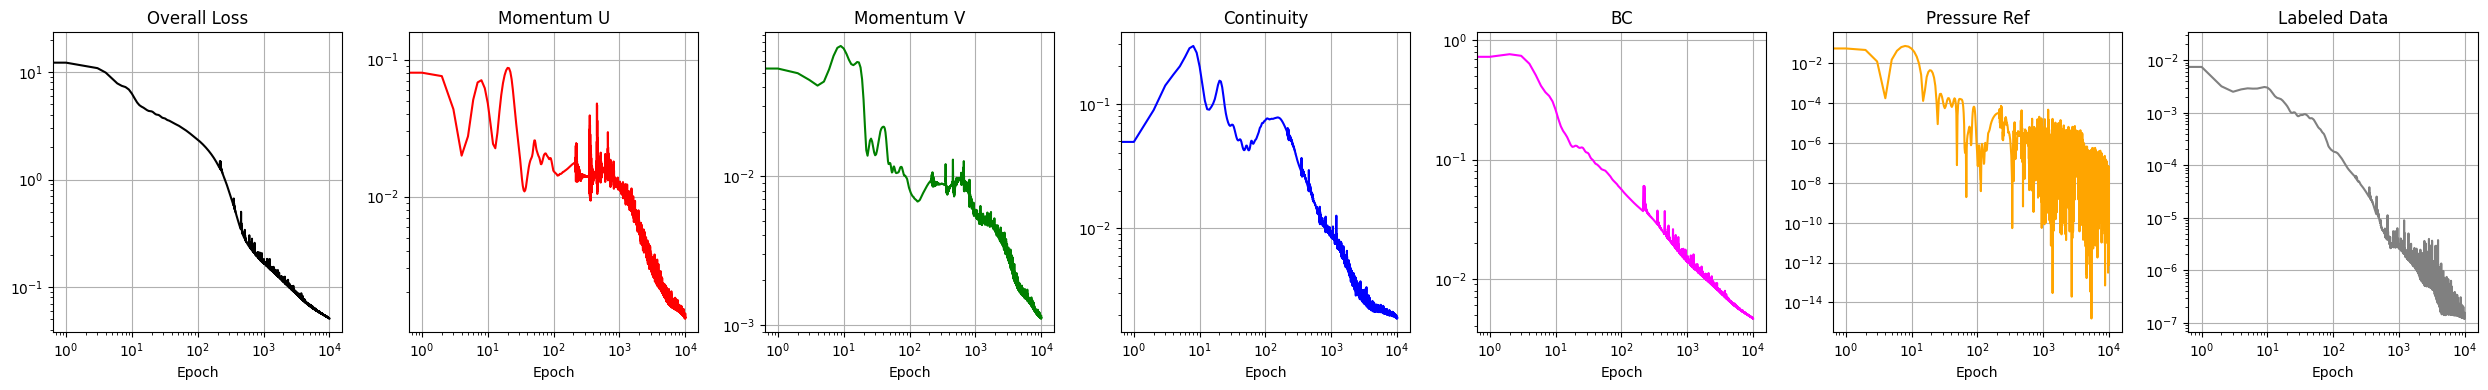

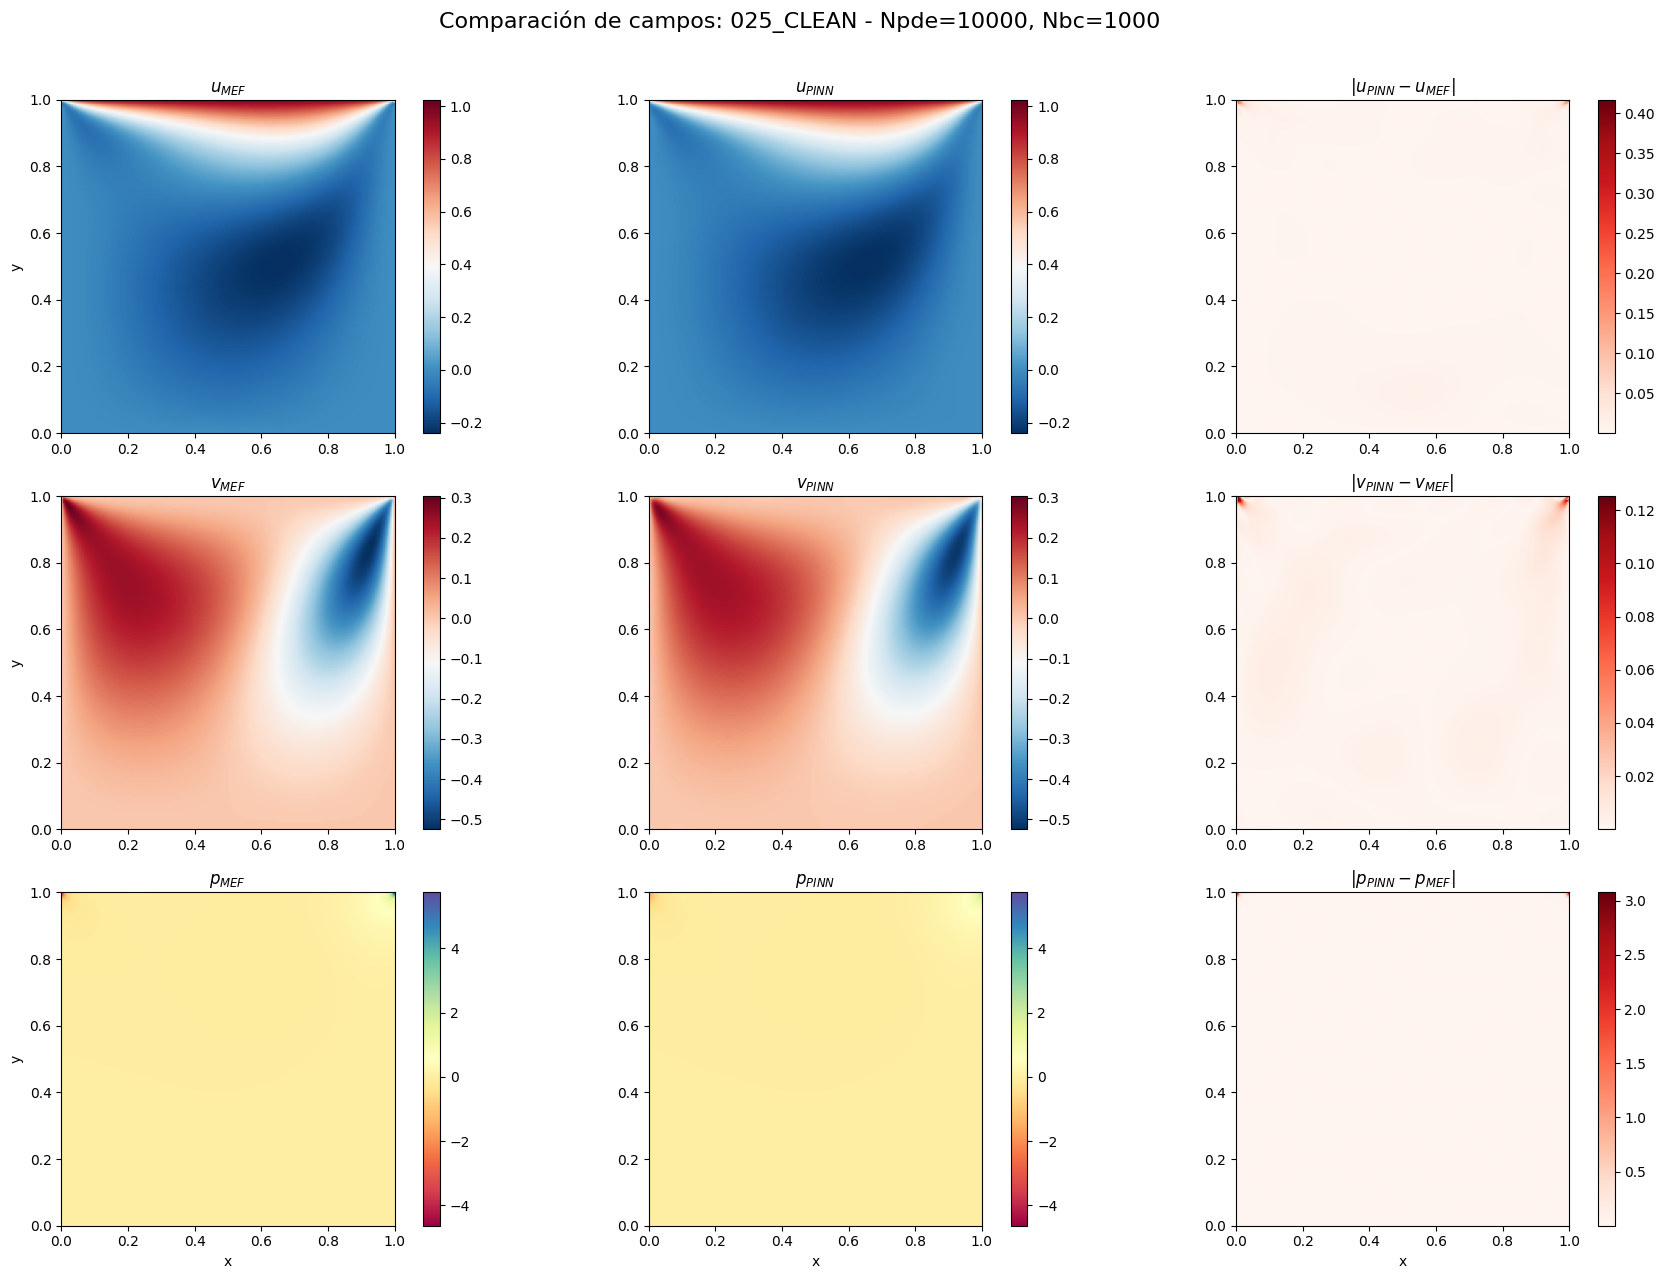

/tmp/ipykernel_75242/238890141.py:49: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend()


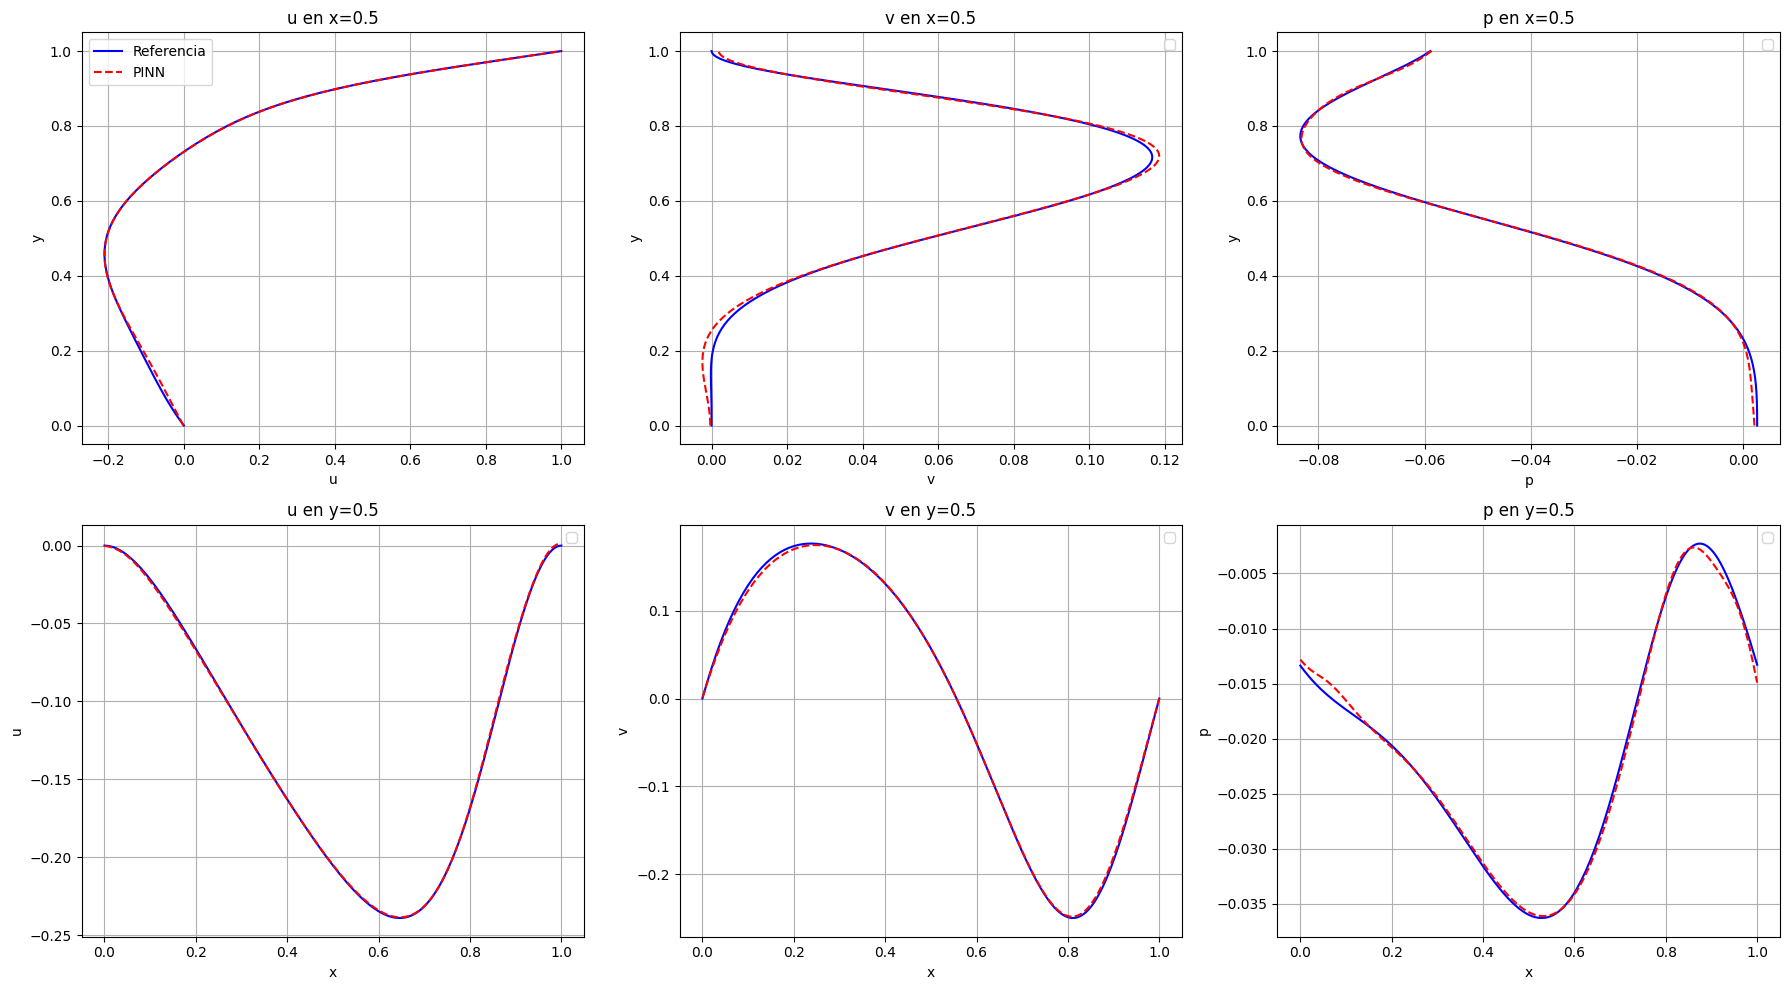


=== Entrenando modelo: 025_noisy ===
Iniciando entrenamiento ...


Entrenando modelo PINN:   0%|          | 5/10000 [00:00<03:26, 48.41it/s]

Epoch    0 | Total: 1.75e+01 | PDE: 4.13e-01 | BC: 8.96e-01 | P_ref: 2.25e-02 | p(0,0): 0.2358 | u_top: 0.243 | Re: 50.09


Entrenando modelo PINN:   5%|▌         | 510/10000 [00:10<03:14, 48.87it/s]

Epoch  500 | Total: 2.90e-01 | PDE: 4.47e-02 | BC: 2.17e-02 | P_ref: 2.02e-06 | p(0,0): 0.0015 | u_top: 0.954 | Re: 94.95


Entrenando modelo PINN:  10%|█         | 1006/10000 [00:20<03:05, 48.39it/s]

Epoch 1000 | Total: 1.68e-01 | PDE: 2.54e-02 | BC: 1.42e-02 | P_ref: 2.68e-07 | p(0,0): -0.0012 | u_top: 0.993 | Re: 100.09


Entrenando modelo PINN:  15%|█▌        | 1508/10000 [00:31<03:11, 44.41it/s]

Epoch 1500 | Total: 1.32e-01 | PDE: 1.91e-02 | BC: 1.12e-02 | P_ref: 1.23e-07 | p(0,0): 0.0001 | u_top: 0.997 | Re: 100.11


Entrenando modelo PINN:  20%|██        | 2010/10000 [00:41<02:48, 47.35it/s]

Epoch 2000 | Total: 1.12e-01 | PDE: 1.48e-02 | BC: 9.68e-03 | P_ref: 1.41e-06 | p(0,0): -0.0001 | u_top: 0.984 | Re: 100.10


Entrenando modelo PINN:  25%|██▌       | 2506/10000 [00:52<02:44, 45.62it/s]

Epoch 2500 | Total: 9.75e-02 | PDE: 1.11e-02 | BC: 8.62e-03 | P_ref: 1.22e-07 | p(0,0): -0.0004 | u_top: 0.986 | Re: 100.09


Entrenando modelo PINN:  30%|███       | 3006/10000 [01:03<02:34, 45.20it/s]

Epoch 3000 | Total: 8.93e-02 | PDE: 8.50e-03 | BC: 8.06e-03 | P_ref: 7.84e-07 | p(0,0): -0.0011 | u_top: 0.999 | Re: 100.07


Entrenando modelo PINN:  35%|███▌      | 3506/10000 [01:13<02:20, 46.09it/s]

Epoch 3500 | Total: 8.05e-02 | PDE: 7.60e-03 | BC: 7.27e-03 | P_ref: 3.60e-07 | p(0,0): -0.0010 | u_top: 0.988 | Re: 100.06


Entrenando modelo PINN:  40%|████      | 4006/10000 [01:24<02:01, 49.19it/s]

Epoch 4000 | Total: 7.53e-02 | PDE: 6.84e-03 | BC: 6.84e-03 | P_ref: 1.21e-07 | p(0,0): -0.0005 | u_top: 0.986 | Re: 100.05


Entrenando modelo PINN:  45%|████▌     | 4506/10000 [01:34<01:59, 45.81it/s]

Epoch 4500 | Total: 7.37e-02 | PDE: 6.70e-03 | BC: 6.64e-03 | P_ref: 6.04e-07 | p(0,0): 0.0004 | u_top: 0.985 | Re: 100.04


Entrenando modelo PINN:  50%|█████     | 5006/10000 [01:45<01:41, 49.36it/s]

Epoch 5000 | Total: 6.77e-02 | PDE: 6.00e-03 | BC: 6.16e-03 | P_ref: 1.03e-08 | p(0,0): -0.0001 | u_top: 0.987 | Re: 100.04


Entrenando modelo PINN:  55%|█████▌    | 5506/10000 [01:55<01:33, 48.17it/s]

Epoch 5500 | Total: 6.40e-02 | PDE: 5.51e-03 | BC: 5.85e-03 | P_ref: 6.91e-08 | p(0,0): -0.0000 | u_top: 0.994 | Re: 100.03


Entrenando modelo PINN:  60%|██████    | 6009/10000 [02:06<01:21, 48.93it/s]

Epoch 6000 | Total: 6.26e-02 | PDE: 5.31e-03 | BC: 5.72e-03 | P_ref: 2.37e-08 | p(0,0): -0.0002 | u_top: 0.997 | Re: 100.03


Entrenando modelo PINN:  65%|██████▌   | 6510/10000 [02:16<01:08, 51.07it/s]

Epoch 6500 | Total: 6.01e-02 | PDE: 5.26e-03 | BC: 5.48e-03 | P_ref: 6.94e-08 | p(0,0): -0.0004 | u_top: 0.992 | Re: 100.03


Entrenando modelo PINN:  70%|███████   | 7009/10000 [02:26<00:59, 50.30it/s]

Epoch 7000 | Total: 5.86e-02 | PDE: 5.07e-03 | BC: 5.34e-03 | P_ref: 7.83e-08 | p(0,0): -0.0004 | u_top: 0.995 | Re: 100.03


Entrenando modelo PINN:  75%|███████▌  | 7507/10000 [02:35<00:50, 49.55it/s]

Epoch 7500 | Total: 5.73e-02 | PDE: 5.11e-03 | BC: 5.21e-03 | P_ref: 1.64e-07 | p(0,0): -0.0001 | u_top: 0.995 | Re: 100.02


Entrenando modelo PINN:  80%|████████  | 8010/10000 [02:46<00:41, 48.09it/s]

Epoch 8000 | Total: 5.59e-02 | PDE: 4.88e-03 | BC: 5.09e-03 | P_ref: 1.64e-07 | p(0,0): -0.0001 | u_top: 0.995 | Re: 100.02


Entrenando modelo PINN:  85%|████████▌ | 8506/10000 [02:56<00:32, 46.26it/s]

Epoch 8500 | Total: 5.46e-02 | PDE: 4.73e-03 | BC: 4.98e-03 | P_ref: 4.66e-08 | p(0,0): -0.0003 | u_top: 0.994 | Re: 100.02


Entrenando modelo PINN:  90%|█████████ | 9006/10000 [03:07<00:21, 46.33it/s]

Epoch 9000 | Total: 5.36e-02 | PDE: 4.63e-03 | BC: 4.89e-03 | P_ref: 4.73e-08 | p(0,0): -0.0002 | u_top: 0.996 | Re: 100.02


Entrenando modelo PINN:  95%|█████████▌| 9508/10000 [03:17<00:10, 49.19it/s]

Epoch 9500 | Total: 5.23e-02 | PDE: 4.49e-03 | BC: 4.78e-03 | P_ref: 5.28e-08 | p(0,0): -0.0002 | u_top: 0.994 | Re: 100.02


Entrenando modelo PINN: 100%|██████████| 10000/10000 [03:27<00:00, 48.11it/s]


Epoch 9999 | Total: 5.13e-02 | PDE: 4.39e-03 | BC: 4.69e-03 | P_ref: 6.18e-08 | p(0,0): -0.0002 | u_top: 0.994 | Re: 100.02

Valor final estimado de Re: 100.0222

Tiempo total: 207.8 segundos
Modelo guardado como: models/pinn_025_noisy_Npde10000_Nbc1000_20250804_000944.pt


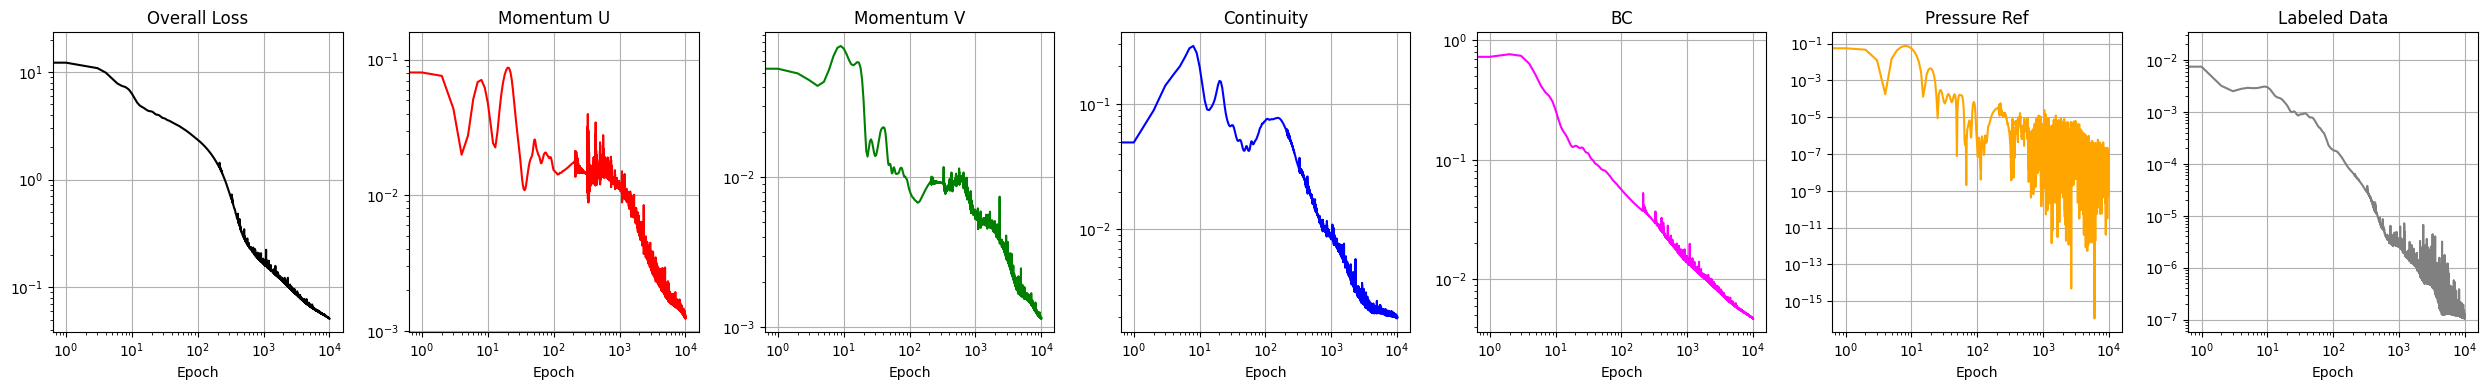

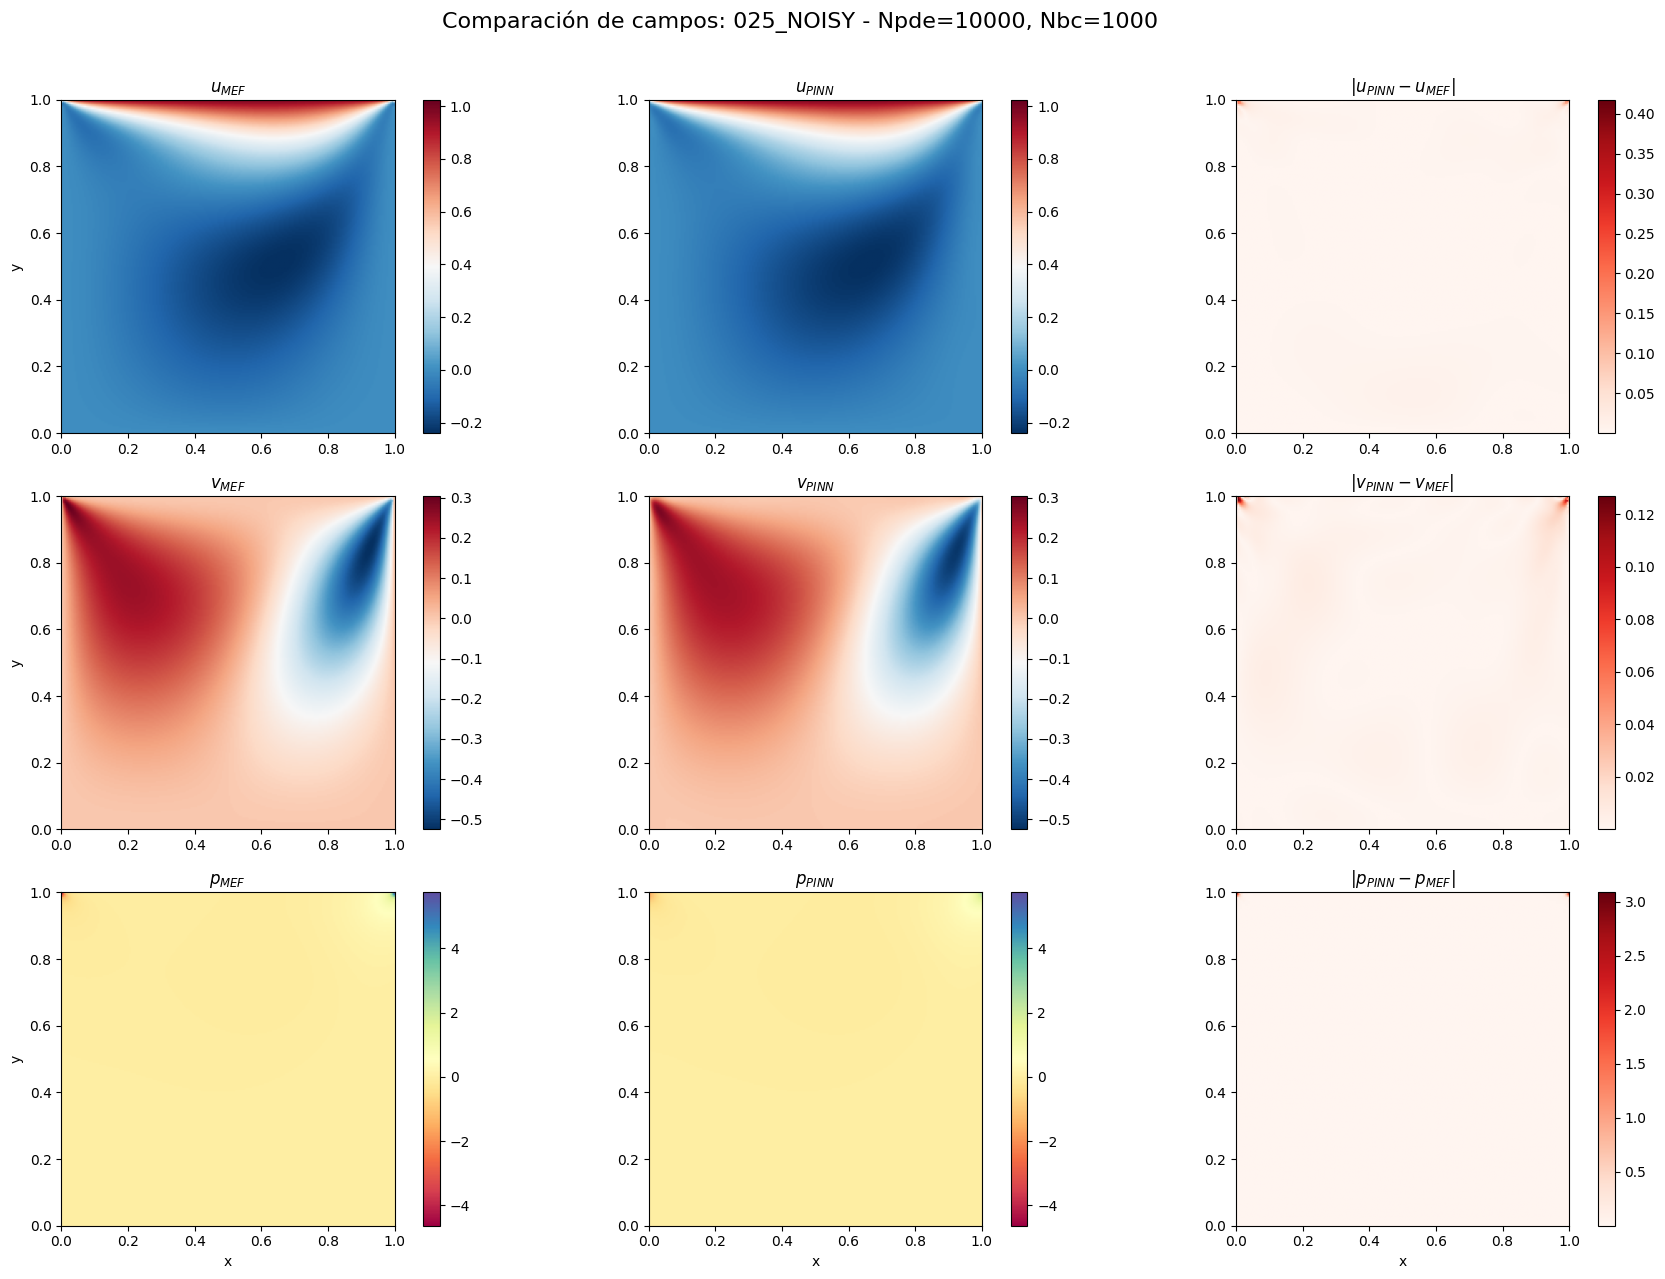

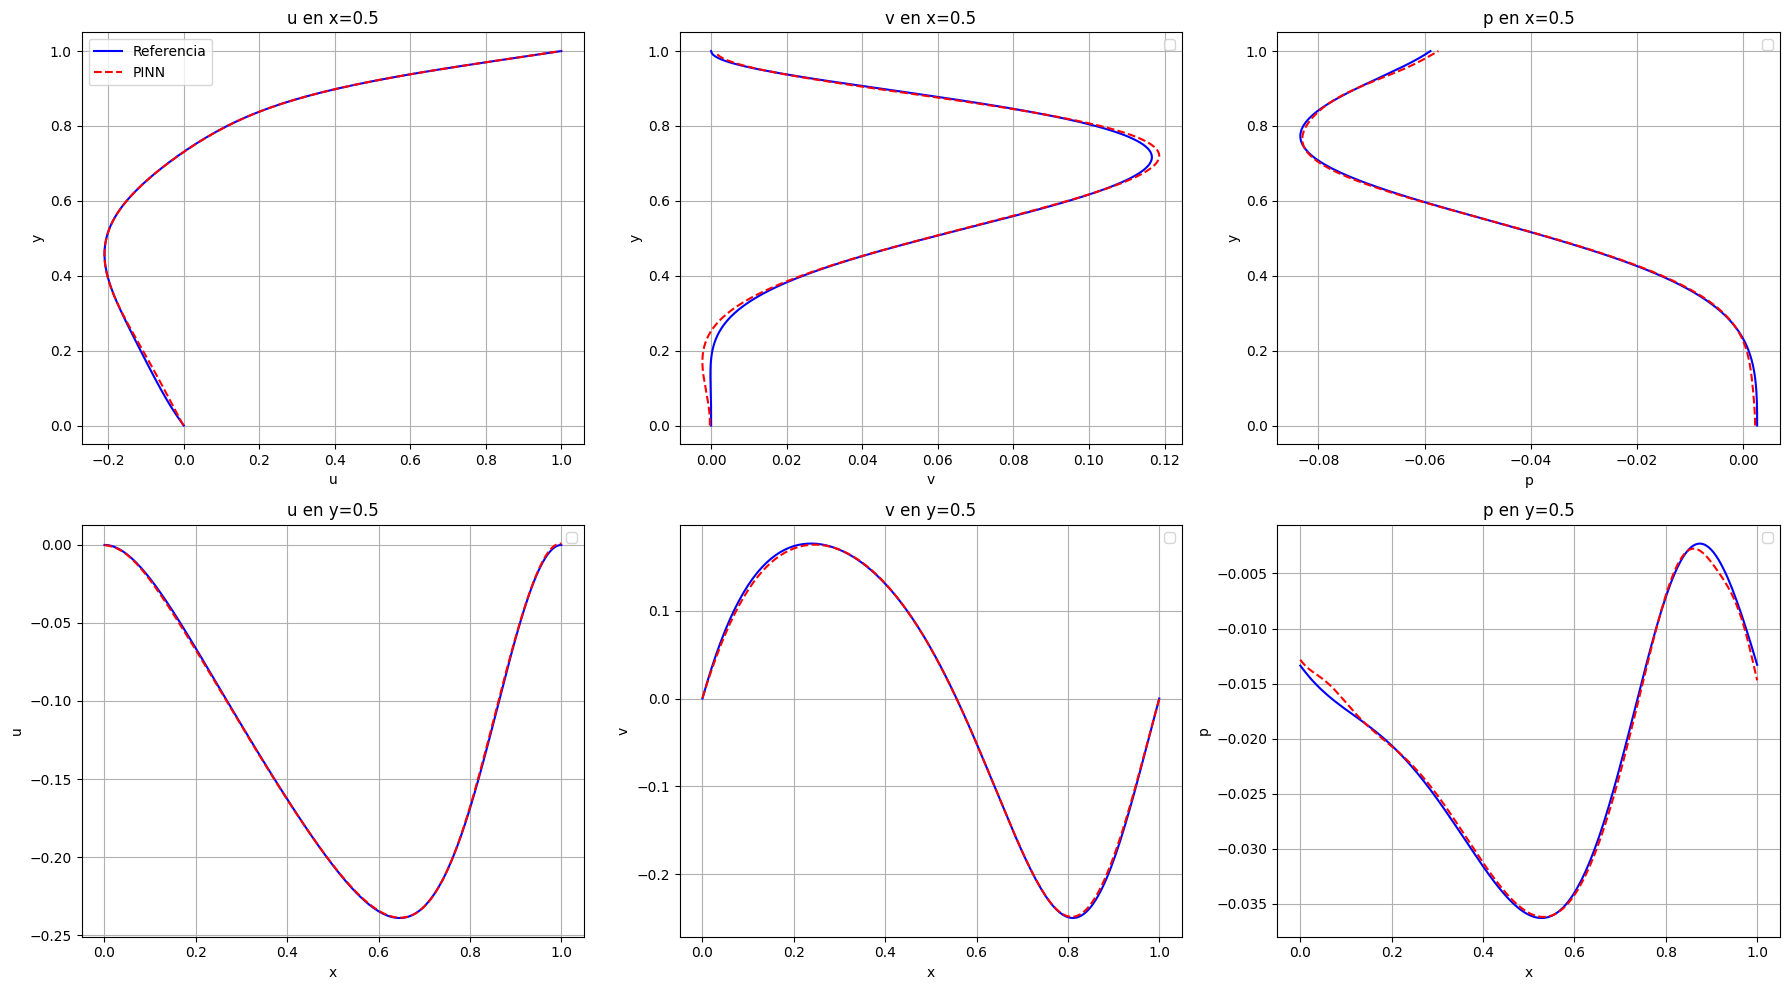


=== Entrenando modelo: 050_clean ===
Iniciando entrenamiento ...


Entrenando modelo PINN:   0%|          | 5/10000 [00:00<03:39, 45.52it/s]

Epoch    0 | Total: 1.67e+01 | PDE: 4.13e-01 | BC: 8.96e-01 | P_ref: 2.25e-02 | p(0,0): 0.2306 | u_top: 0.233 | Re: 50.09


Entrenando modelo PINN:   5%|▌         | 507/10000 [00:10<03:11, 49.68it/s]

Epoch  500 | Total: 2.88e-01 | PDE: 3.85e-02 | BC: 2.19e-02 | P_ref: 2.43e-06 | p(0,0): 0.0015 | u_top: 0.977 | Re: 94.92


Entrenando modelo PINN:  10%|█         | 1009/10000 [00:20<03:08, 47.76it/s]

Epoch 1000 | Total: 1.70e-01 | PDE: 2.44e-02 | BC: 1.45e-02 | P_ref: 1.56e-07 | p(0,0): -0.0009 | u_top: 0.977 | Re: 100.07


Entrenando modelo PINN:  15%|█▌        | 1510/10000 [00:31<03:03, 46.38it/s]

Epoch 1500 | Total: 1.36e-01 | PDE: 1.89e-02 | BC: 1.16e-02 | P_ref: 7.66e-07 | p(0,0): 0.0006 | u_top: 0.984 | Re: 100.09


Entrenando modelo PINN:  20%|██        | 2008/10000 [00:41<02:52, 46.38it/s]

Epoch 2000 | Total: 1.12e-01 | PDE: 1.41e-02 | BC: 9.81e-03 | P_ref: 2.58e-06 | p(0,0): 0.0014 | u_top: 0.982 | Re: 100.09


Entrenando modelo PINN:  25%|██▌       | 2509/10000 [00:52<02:33, 48.84it/s]

Epoch 2500 | Total: 1.04e-01 | PDE: 1.25e-02 | BC: 9.08e-03 | P_ref: 6.05e-06 | p(0,0): 0.0006 | u_top: 0.989 | Re: 100.08


Entrenando modelo PINN:  30%|███       | 3006/10000 [01:02<02:16, 51.06it/s]

Epoch 3000 | Total: 8.85e-02 | PDE: 9.03e-03 | BC: 7.92e-03 | P_ref: 7.29e-07 | p(0,0): 0.0013 | u_top: 0.987 | Re: 100.07


Entrenando modelo PINN:  35%|███▌      | 3509/10000 [01:12<02:22, 45.43it/s]

Epoch 3500 | Total: 8.10e-02 | PDE: 7.45e-03 | BC: 7.33e-03 | P_ref: 1.08e-06 | p(0,0): 0.0007 | u_top: 0.996 | Re: 100.06


Entrenando modelo PINN:  40%|████      | 4007/10000 [01:22<02:03, 48.55it/s]

Epoch 4000 | Total: 7.50e-02 | PDE: 6.55e-03 | BC: 6.83e-03 | P_ref: 1.41e-07 | p(0,0): 0.0002 | u_top: 0.997 | Re: 100.05


Entrenando modelo PINN:  45%|████▌     | 4508/10000 [01:33<01:52, 49.03it/s]

Epoch 4500 | Total: 7.01e-02 | PDE: 6.04e-03 | BC: 6.39e-03 | P_ref: 2.96e-09 | p(0,0): 0.0002 | u_top: 0.992 | Re: 100.04


Entrenando modelo PINN:  50%|█████     | 5009/10000 [01:43<01:43, 48.41it/s]

Epoch 5000 | Total: 6.73e-02 | PDE: 5.76e-03 | BC: 6.13e-03 | P_ref: 2.38e-09 | p(0,0): 0.0002 | u_top: 0.991 | Re: 100.04


Entrenando modelo PINN:  55%|█████▌    | 5510/10000 [01:54<01:32, 48.48it/s]

Epoch 5500 | Total: 6.46e-02 | PDE: 5.35e-03 | BC: 5.91e-03 | P_ref: 1.06e-09 | p(0,0): -0.0000 | u_top: 0.995 | Re: 100.04


Entrenando modelo PINN:  60%|██████    | 6008/10000 [02:04<01:21, 48.85it/s]

Epoch 6000 | Total: 6.29e-02 | PDE: 5.18e-03 | BC: 5.76e-03 | P_ref: 2.28e-09 | p(0,0): 0.0001 | u_top: 0.996 | Re: 100.03


Entrenando modelo PINN:  65%|██████▌   | 6508/10000 [02:14<01:17, 44.97it/s]

Epoch 6500 | Total: 6.11e-02 | PDE: 4.95e-03 | BC: 5.60e-03 | P_ref: 5.89e-10 | p(0,0): 0.0000 | u_top: 0.993 | Re: 100.03


Entrenando modelo PINN:  70%|███████   | 7010/10000 [02:25<01:01, 48.57it/s]

Epoch 7000 | Total: 5.96e-02 | PDE: 4.73e-03 | BC: 5.48e-03 | P_ref: 4.03e-09 | p(0,0): 0.0001 | u_top: 0.994 | Re: 100.03


Entrenando modelo PINN:  75%|███████▌  | 7506/10000 [02:36<00:54, 45.86it/s]

Epoch 7500 | Total: 5.83e-02 | PDE: 4.57e-03 | BC: 5.36e-03 | P_ref: 1.24e-08 | p(0,0): 0.0001 | u_top: 0.995 | Re: 100.02


Entrenando modelo PINN:  80%|████████  | 8006/10000 [02:46<00:43, 46.19it/s]

Epoch 8000 | Total: 5.71e-02 | PDE: 4.52e-03 | BC: 5.25e-03 | P_ref: 3.42e-09 | p(0,0): 0.0003 | u_top: 0.994 | Re: 100.02


Entrenando modelo PINN:  85%|████████▌ | 8506/10000 [02:57<00:32, 46.16it/s]

Epoch 8500 | Total: 5.59e-02 | PDE: 4.30e-03 | BC: 5.15e-03 | P_ref: 8.29e-09 | p(0,0): 0.0001 | u_top: 0.995 | Re: 100.02


Entrenando modelo PINN:  90%|█████████ | 9007/10000 [03:07<00:20, 48.62it/s]

Epoch 9000 | Total: 5.48e-02 | PDE: 4.14e-03 | BC: 5.05e-03 | P_ref: 1.26e-08 | p(0,0): 0.0000 | u_top: 0.995 | Re: 100.02


Entrenando modelo PINN:  95%|█████████▌| 9510/10000 [03:18<00:10, 47.22it/s]

Epoch 9500 | Total: 5.36e-02 | PDE: 4.01e-03 | BC: 4.95e-03 | P_ref: 9.25e-10 | p(0,0): 0.0000 | u_top: 0.995 | Re: 100.01


Entrenando modelo PINN: 100%|██████████| 10000/10000 [03:29<00:00, 47.84it/s]


Epoch 9999 | Total: 5.25e-02 | PDE: 3.85e-03 | BC: 4.86e-03 | P_ref: 2.87e-10 | p(0,0): -0.0000 | u_top: 0.995 | Re: 100.01

Valor final estimado de Re: 100.0129

Tiempo total: 209.0 segundos
Modelo guardado como: models/pinn_050_clean_Npde10000_Nbc1000_20250804_001319.pt


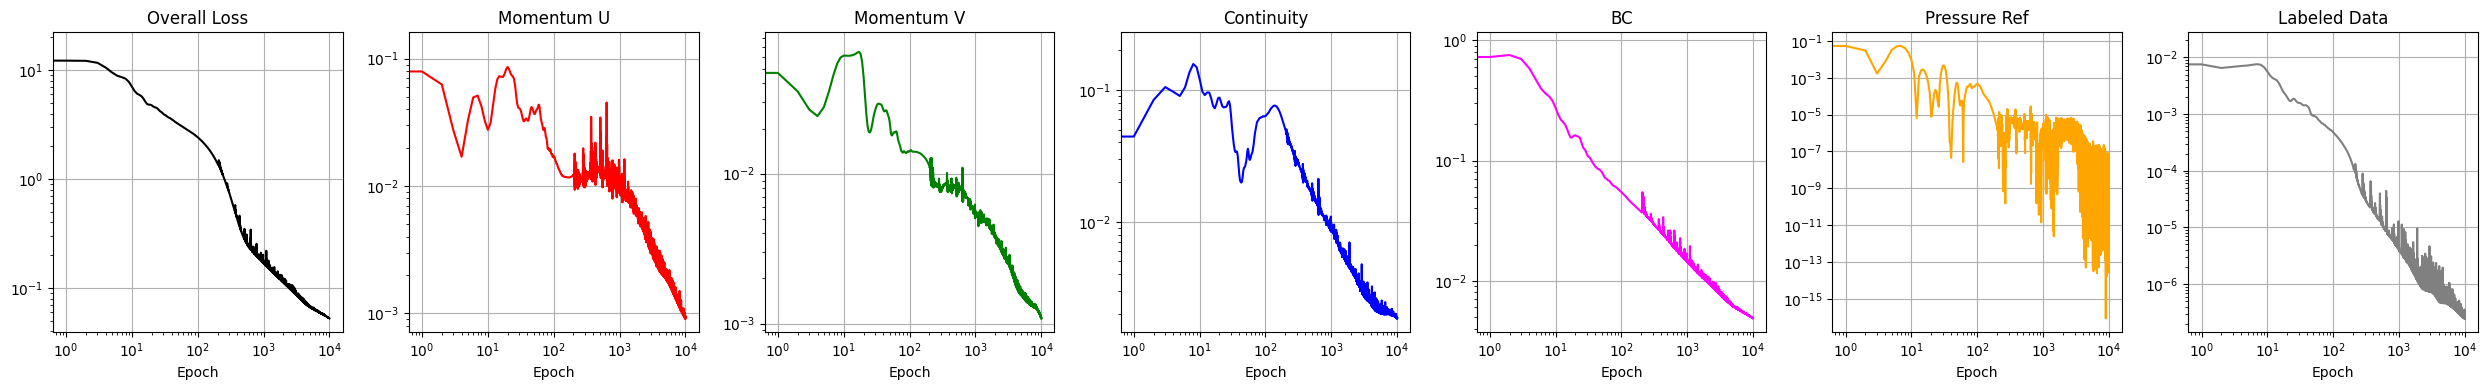

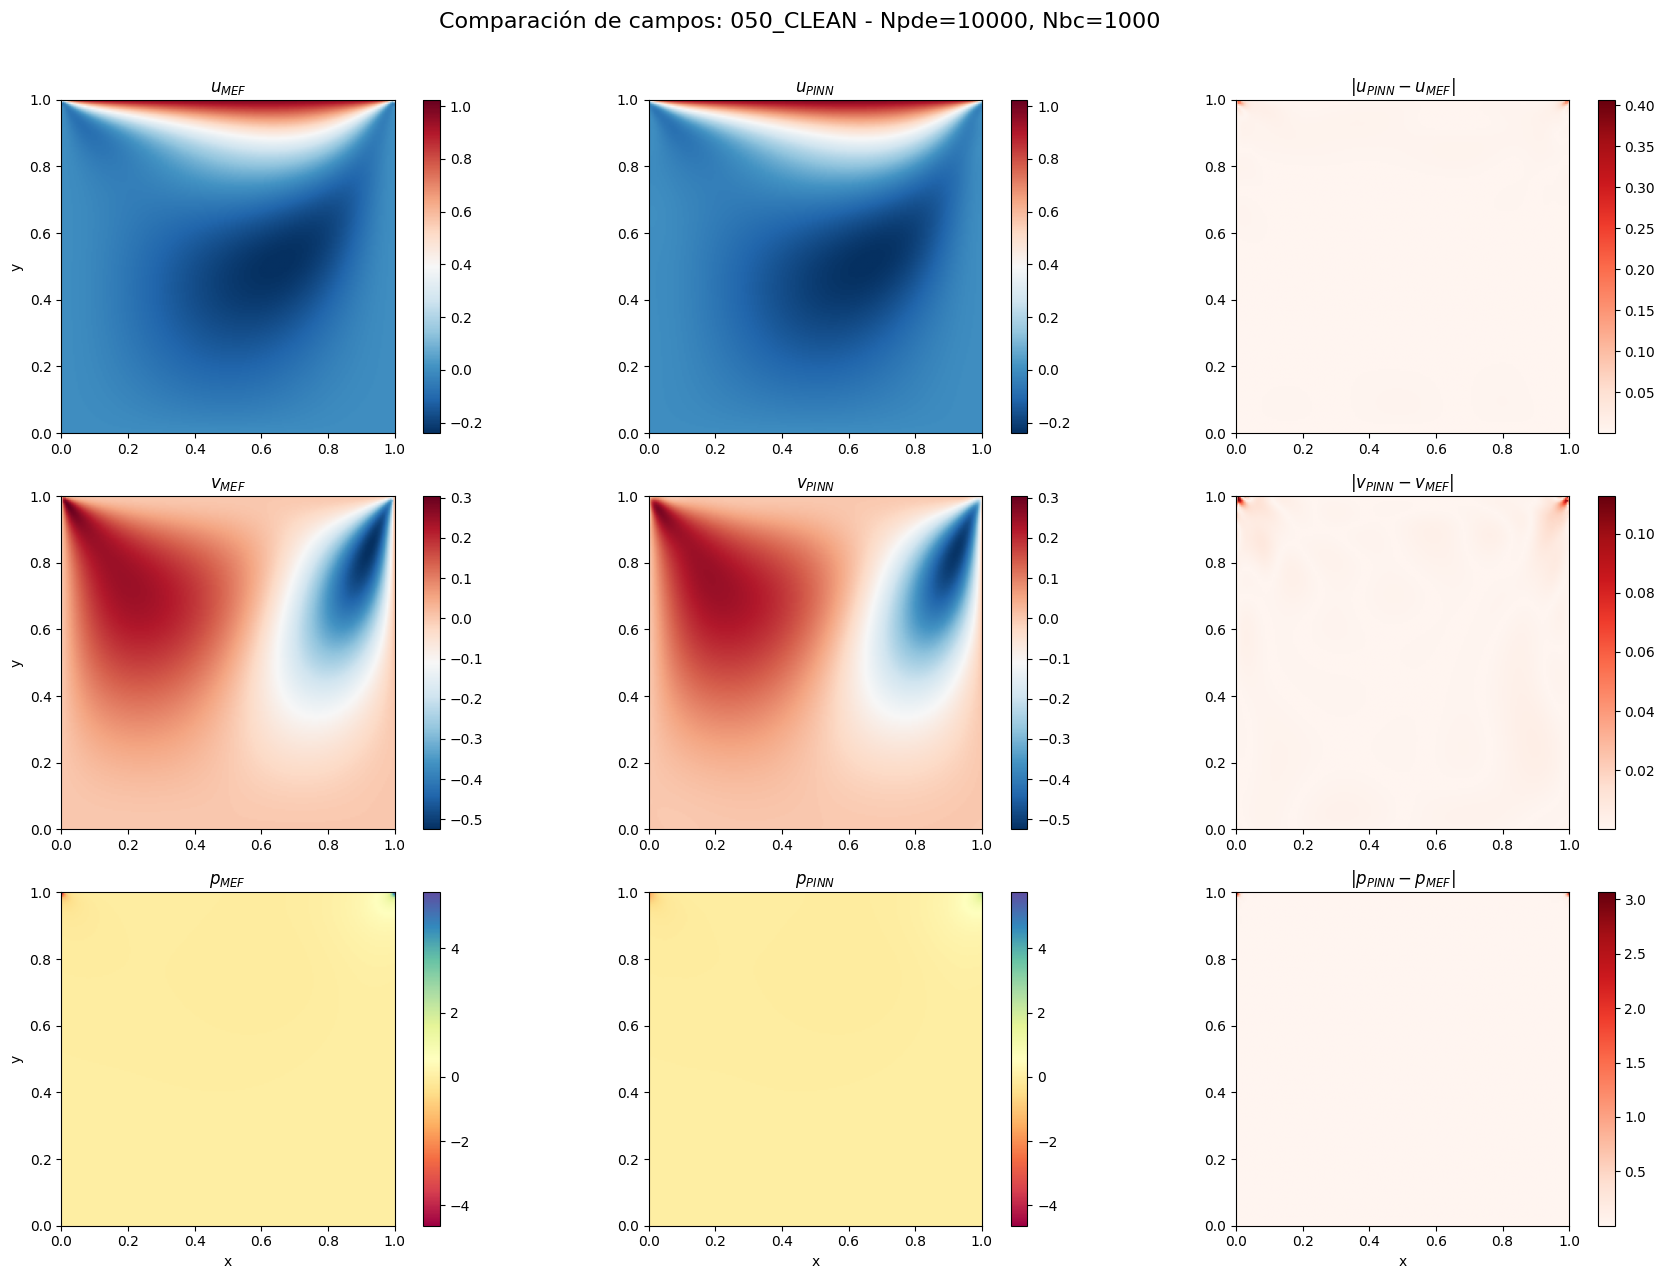

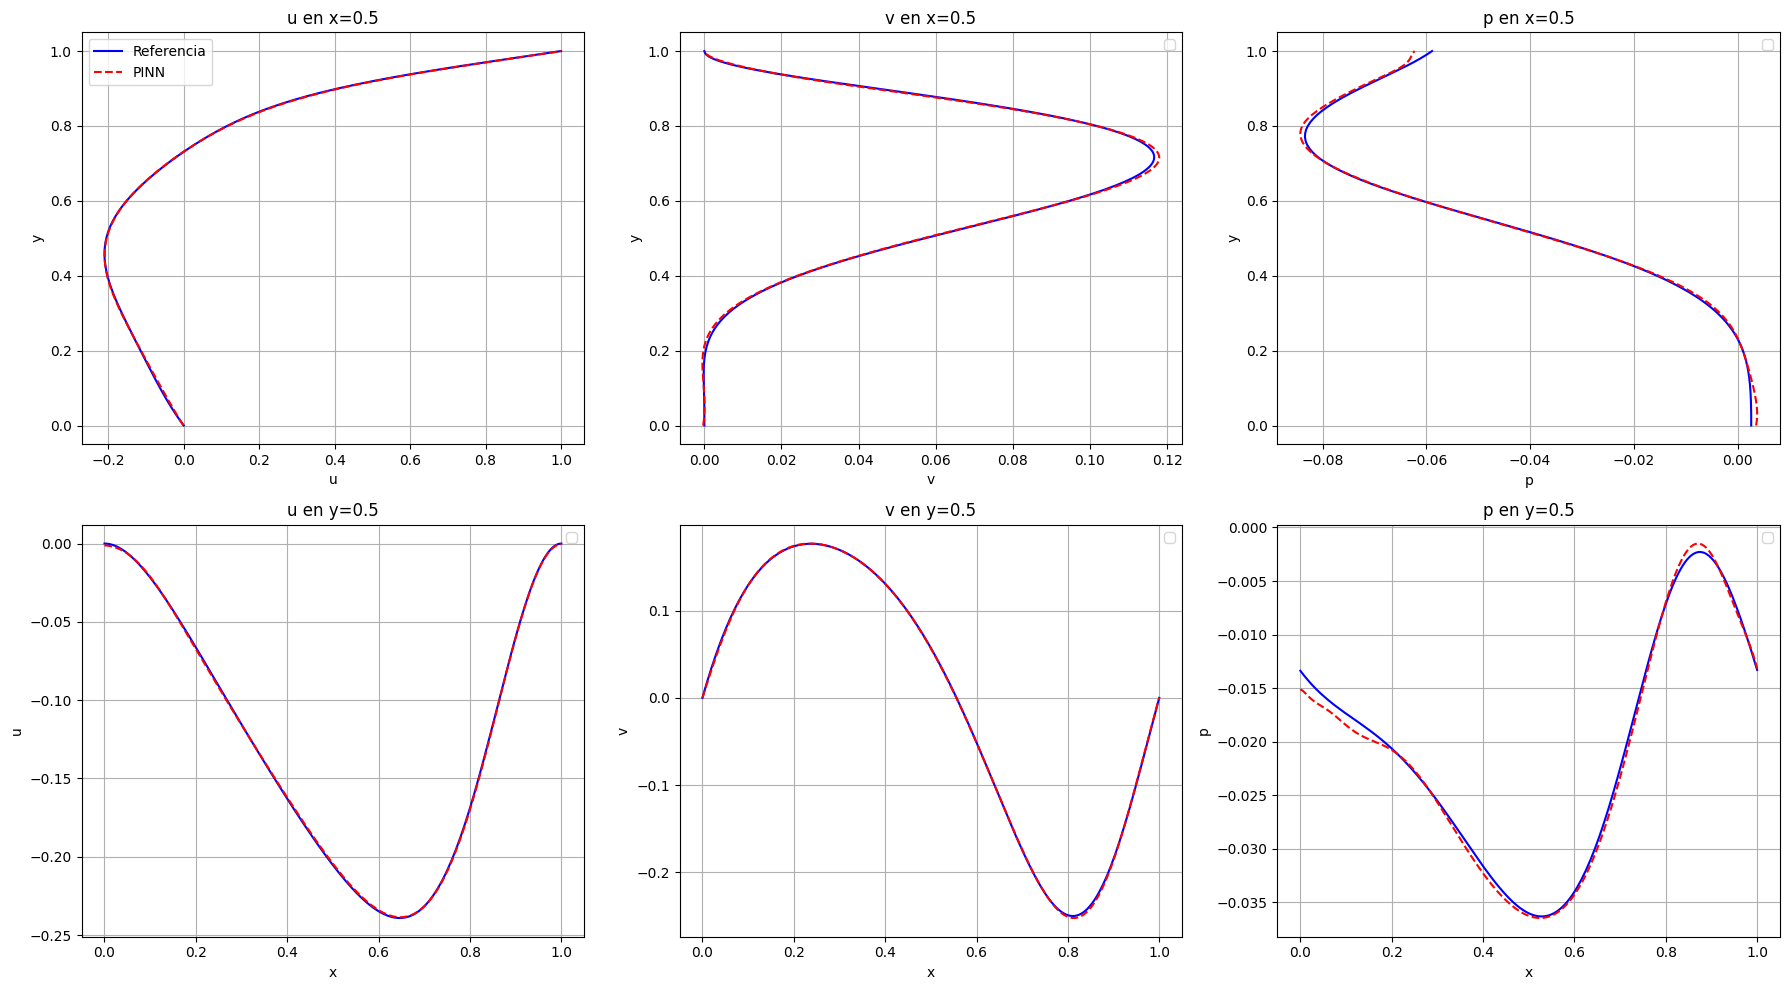


=== Entrenando modelo: 050_noisy ===
Iniciando entrenamiento ...


Entrenando modelo PINN:   0%|          | 5/10000 [00:00<03:55, 42.49it/s]

Epoch    0 | Total: 1.67e+01 | PDE: 4.13e-01 | BC: 8.96e-01 | P_ref: 2.25e-02 | p(0,0): 0.2306 | u_top: 0.233 | Re: 50.09


Entrenando modelo PINN:   5%|▌         | 505/10000 [00:11<03:35, 44.10it/s]

Epoch  500 | Total: 2.85e-01 | PDE: 3.87e-02 | BC: 2.16e-02 | P_ref: 3.60e-06 | p(0,0): 0.0019 | u_top: 0.969 | Re: 94.92


Entrenando modelo PINN:  10%|█         | 1010/10000 [00:22<03:13, 46.42it/s]

Epoch 1000 | Total: 1.67e-01 | PDE: 2.33e-02 | BC: 1.43e-02 | P_ref: 1.83e-06 | p(0,0): -0.0013 | u_top: 0.987 | Re: 100.07


Entrenando modelo PINN:  15%|█▌        | 1510/10000 [00:32<03:02, 46.61it/s]

Epoch 1500 | Total: 1.33e-01 | PDE: 1.79e-02 | BC: 1.14e-02 | P_ref: 4.20e-08 | p(0,0): 0.0006 | u_top: 0.978 | Re: 100.09


Entrenando modelo PINN:  20%|██        | 2010/10000 [00:43<02:45, 48.34it/s]

Epoch 2000 | Total: 1.19e-01 | PDE: 1.30e-02 | BC: 1.05e-02 | P_ref: 1.41e-06 | p(0,0): 0.0015 | u_top: 1.005 | Re: 100.09


Entrenando modelo PINN:  25%|██▌       | 2508/10000 [00:53<02:35, 48.15it/s]

Epoch 2500 | Total: 9.83e-02 | PDE: 1.10e-02 | BC: 8.69e-03 | P_ref: 2.45e-06 | p(0,0): 0.0019 | u_top: 0.986 | Re: 100.08


Entrenando modelo PINN:  30%|███       | 3007/10000 [01:03<02:18, 50.33it/s]

Epoch 3000 | Total: 8.81e-02 | PDE: 8.80e-03 | BC: 7.91e-03 | P_ref: 1.30e-06 | p(0,0): 0.0011 | u_top: 0.994 | Re: 100.07


Entrenando modelo PINN:  35%|███▌      | 3508/10000 [01:13<02:07, 50.98it/s]

Epoch 3500 | Total: 8.18e-02 | PDE: 7.96e-03 | BC: 7.35e-03 | P_ref: 1.96e-07 | p(0,0): 0.0009 | u_top: 0.992 | Re: 100.06


Entrenando modelo PINN:  40%|████      | 4007/10000 [01:23<02:03, 48.39it/s]

Epoch 4000 | Total: 7.48e-02 | PDE: 6.86e-03 | BC: 6.77e-03 | P_ref: 2.34e-07 | p(0,0): 0.0001 | u_top: 0.989 | Re: 100.05


Entrenando modelo PINN:  45%|████▌     | 4510/10000 [01:34<01:52, 48.86it/s]

Epoch 4500 | Total: 7.19e-02 | PDE: 6.00e-03 | BC: 6.56e-03 | P_ref: 2.56e-07 | p(0,0): -0.0002 | u_top: 0.999 | Re: 100.04


Entrenando modelo PINN:  50%|█████     | 5009/10000 [01:44<01:41, 49.33it/s]

Epoch 5000 | Total: 6.70e-02 | PDE: 5.73e-03 | BC: 6.11e-03 | P_ref: 4.29e-09 | p(0,0): 0.0001 | u_top: 0.990 | Re: 100.04


Entrenando modelo PINN:  55%|█████▌    | 5511/10000 [01:54<01:30, 49.76it/s]

Epoch 5500 | Total: 6.44e-02 | PDE: 5.32e-03 | BC: 5.89e-03 | P_ref: 2.13e-09 | p(0,0): 0.0000 | u_top: 0.994 | Re: 100.03


Entrenando modelo PINN:  60%|██████    | 6007/10000 [02:04<01:21, 49.05it/s]

Epoch 6000 | Total: 6.26e-02 | PDE: 5.05e-03 | BC: 5.74e-03 | P_ref: 2.19e-08 | p(0,0): -0.0000 | u_top: 0.995 | Re: 100.03


Entrenando modelo PINN:  65%|██████▌   | 6509/10000 [02:14<01:16, 45.61it/s]

Epoch 6500 | Total: 6.11e-02 | PDE: 4.99e-03 | BC: 5.59e-03 | P_ref: 6.92e-10 | p(0,0): 0.0002 | u_top: 0.992 | Re: 100.03


Entrenando modelo PINN:  70%|███████   | 7009/10000 [02:25<01:06, 44.90it/s]

Epoch 7000 | Total: 5.95e-02 | PDE: 4.76e-03 | BC: 5.46e-03 | P_ref: 1.25e-08 | p(0,0): 0.0001 | u_top: 0.994 | Re: 100.03


Entrenando modelo PINN:  75%|███████▌  | 7509/10000 [02:36<00:55, 44.73it/s]

Epoch 7500 | Total: 5.81e-02 | PDE: 4.58e-03 | BC: 5.34e-03 | P_ref: 7.00e-09 | p(0,0): 0.0002 | u_top: 0.994 | Re: 100.02


Entrenando modelo PINN:  80%|████████  | 8009/10000 [02:47<00:44, 44.68it/s]

Epoch 8000 | Total: 5.69e-02 | PDE: 4.45e-03 | BC: 5.24e-03 | P_ref: 3.29e-08 | p(0,0): 0.0001 | u_top: 0.994 | Re: 100.02


Entrenando modelo PINN:  85%|████████▌ | 8509/10000 [02:58<00:32, 45.33it/s]

Epoch 8500 | Total: 5.57e-02 | PDE: 4.27e-03 | BC: 5.13e-03 | P_ref: 2.60e-08 | p(0,0): 0.0002 | u_top: 0.994 | Re: 100.02


Entrenando modelo PINN:  90%|█████████ | 9010/10000 [03:09<00:19, 50.36it/s]

Epoch 9000 | Total: 5.46e-02 | PDE: 4.13e-03 | BC: 5.04e-03 | P_ref: 1.02e-08 | p(0,0): 0.0002 | u_top: 0.995 | Re: 100.02


Entrenando modelo PINN:  95%|█████████▌| 9509/10000 [03:19<00:10, 49.06it/s]

Epoch 9500 | Total: 5.35e-02 | PDE: 3.97e-03 | BC: 4.94e-03 | P_ref: 1.27e-08 | p(0,0): 0.0001 | u_top: 0.995 | Re: 100.01


Entrenando modelo PINN: 100%|██████████| 10000/10000 [03:29<00:00, 47.72it/s]


Epoch 9999 | Total: 5.27e-02 | PDE: 3.89e-03 | BC: 4.87e-03 | P_ref: 2.30e-08 | p(0,0): -0.0001 | u_top: 0.997 | Re: 100.01

Valor final estimado de Re: 100.0127

Tiempo total: 209.6 segundos
Modelo guardado como: models/pinn_050_noisy_Npde10000_Nbc1000_20250804_001654.pt


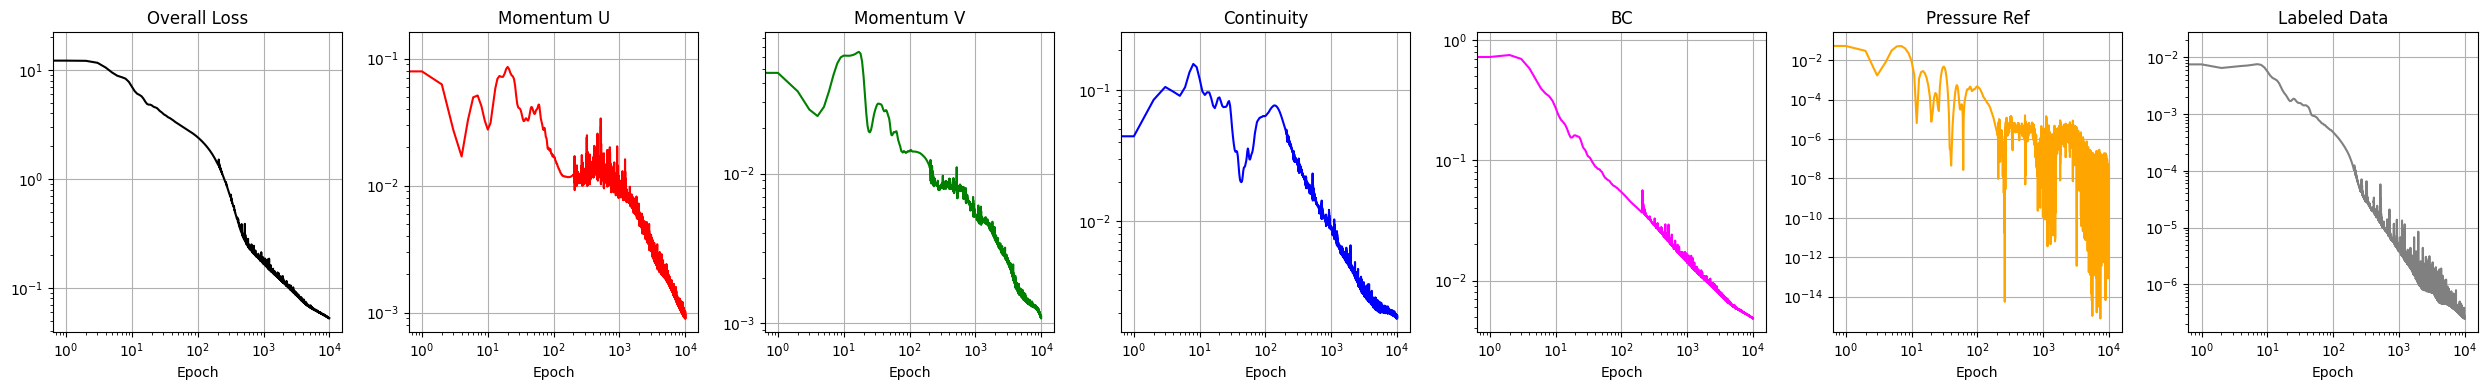

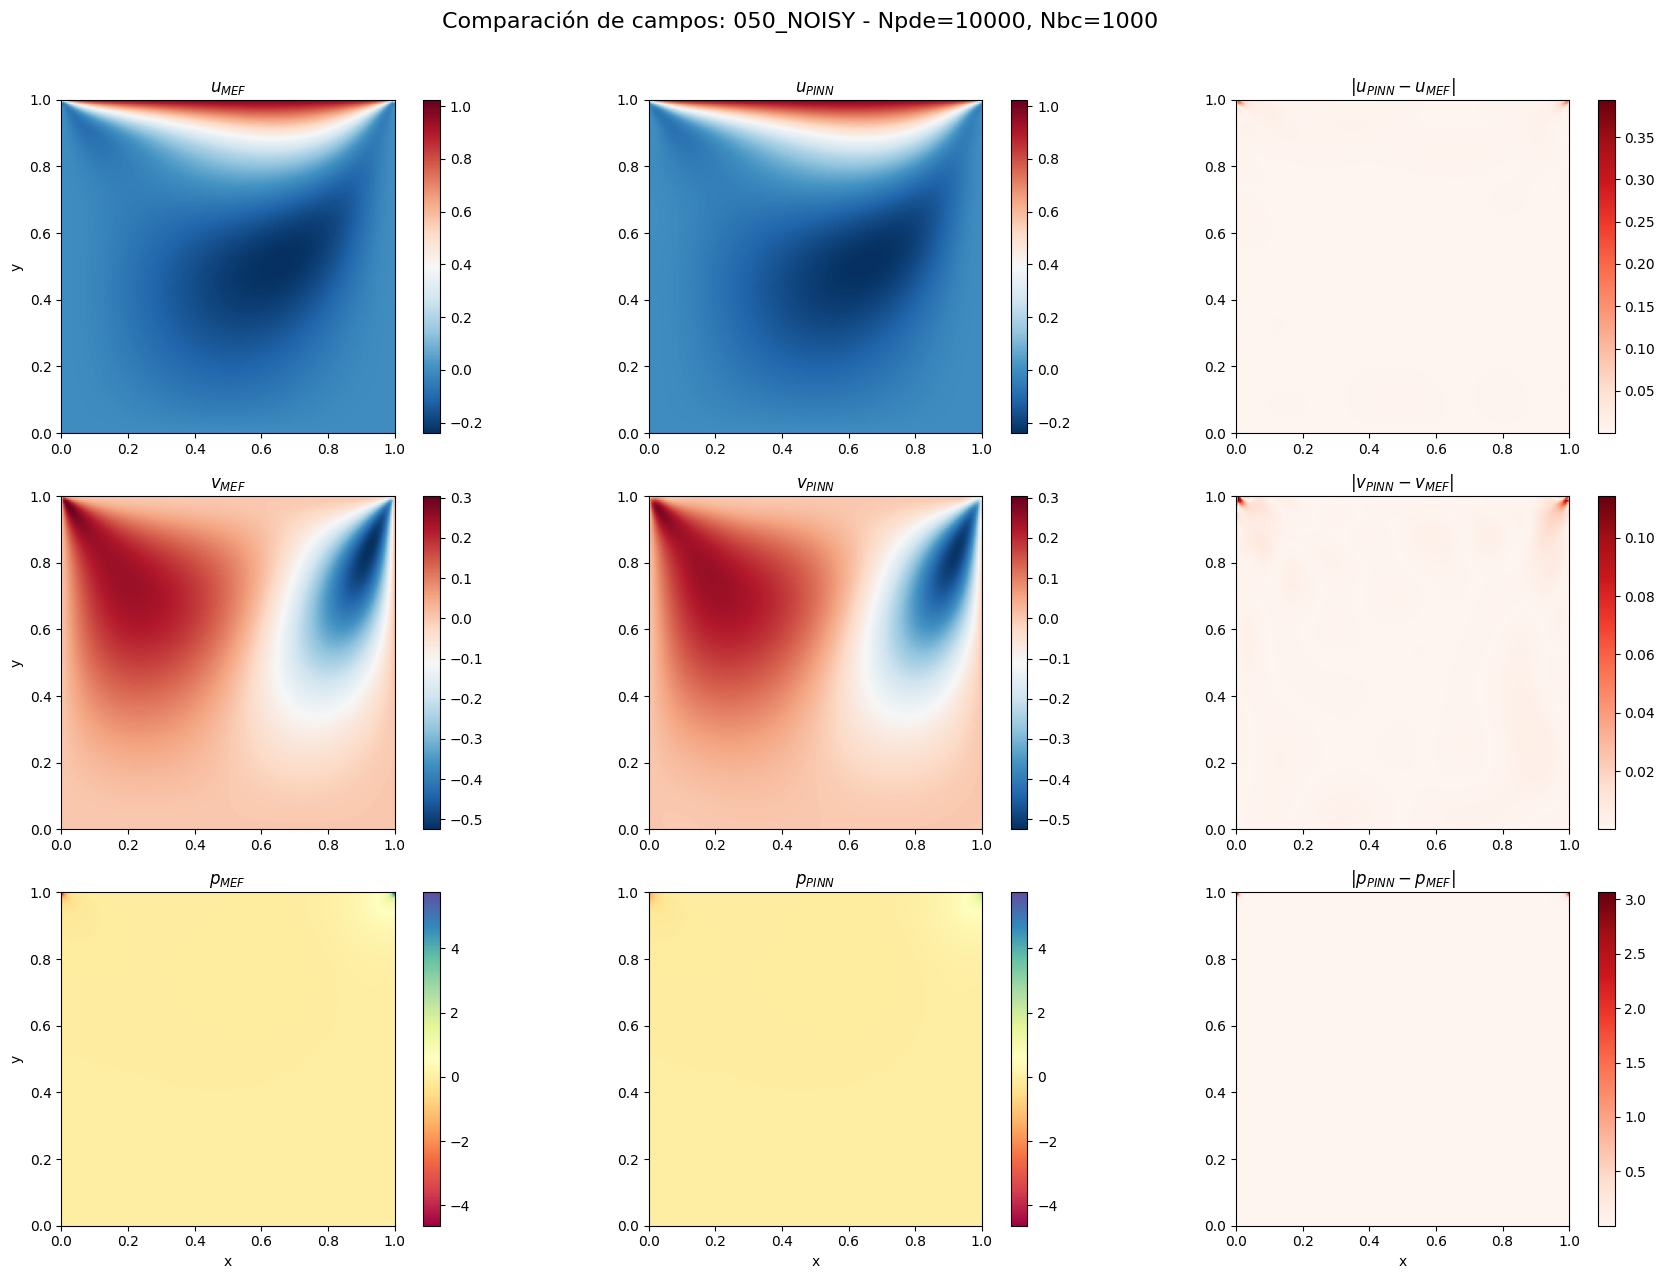

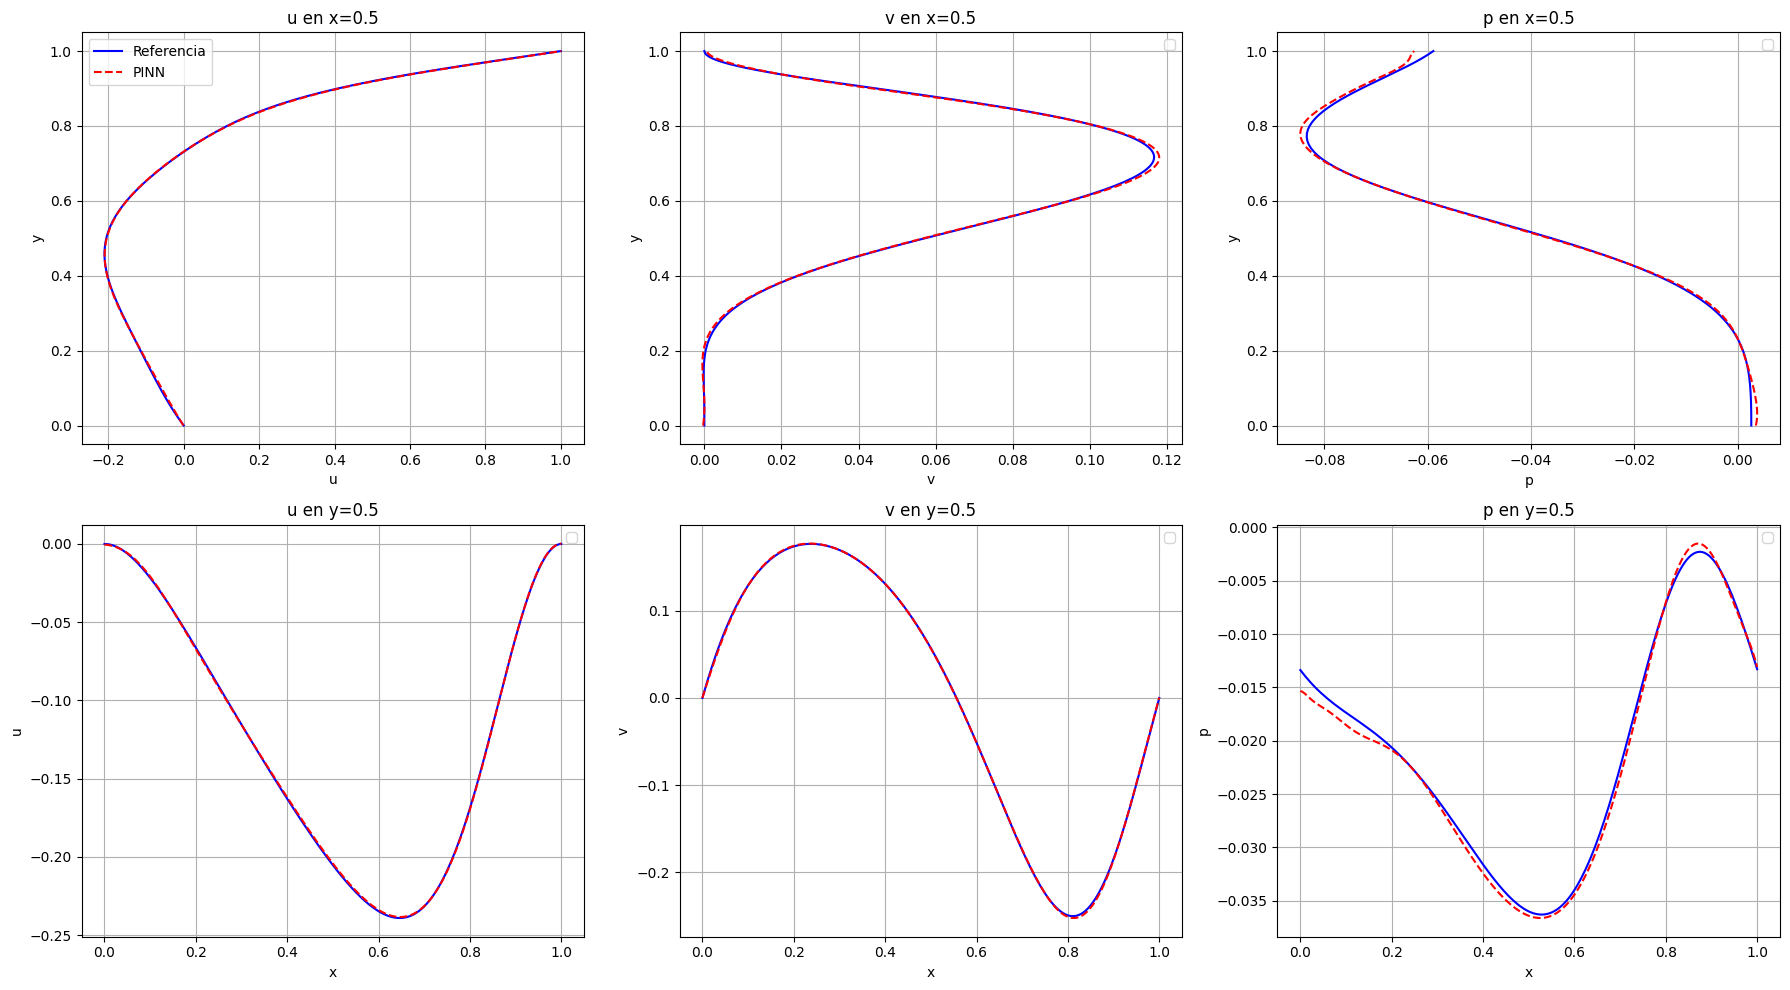


=== Entrenando modelo: 075_clean ===
Iniciando entrenamiento ...


Entrenando modelo PINN:   0%|          | 5/10000 [00:00<03:41, 45.14it/s]

Epoch    0 | Total: 1.90e+01 | PDE: 4.13e-01 | BC: 8.96e-01 | P_ref: 2.25e-02 | p(0,0): 0.2052 | u_top: 0.232 | Re: 50.09


Entrenando modelo PINN:   5%|▌         | 506/10000 [00:10<03:14, 48.91it/s]

Epoch  500 | Total: 2.72e-01 | PDE: 3.54e-02 | BC: 2.04e-02 | P_ref: 1.23e-05 | p(0,0): 0.0036 | u_top: 0.973 | Re: 94.91


Entrenando modelo PINN:  10%|█         | 1006/10000 [00:21<03:06, 48.25it/s]

Epoch 1000 | Total: 1.67e-01 | PDE: 2.26e-02 | BC: 1.43e-02 | P_ref: 2.31e-06 | p(0,0): 0.0010 | u_top: 0.983 | Re: 100.08


Entrenando modelo PINN:  15%|█▌        | 1507/10000 [00:31<03:00, 47.09it/s]

Epoch 1500 | Total: 1.38e-01 | PDE: 1.64e-02 | BC: 1.20e-02 | P_ref: 3.01e-06 | p(0,0): 0.0014 | u_top: 0.973 | Re: 100.09


Entrenando modelo PINN:  20%|██        | 2007/10000 [00:42<02:59, 44.52it/s]

Epoch 2000 | Total: 1.20e-01 | PDE: 1.45e-02 | BC: 1.02e-02 | P_ref: 1.67e-09 | p(0,0): 0.0029 | u_top: 0.986 | Re: 100.09


Entrenando modelo PINN:  25%|██▌       | 2507/10000 [00:53<02:33, 48.92it/s]

Epoch 2500 | Total: 1.01e-01 | PDE: 1.05e-02 | BC: 8.96e-03 | P_ref: 8.09e-07 | p(0,0): 0.0012 | u_top: 0.997 | Re: 100.08


Entrenando modelo PINN:  30%|███       | 3007/10000 [01:03<02:30, 46.45it/s]

Epoch 3000 | Total: 9.02e-02 | PDE: 9.08e-03 | BC: 8.08e-03 | P_ref: 1.25e-07 | p(0,0): 0.0004 | u_top: 0.993 | Re: 100.07


Entrenando modelo PINN:  35%|███▌      | 3510/10000 [01:14<02:14, 48.25it/s]

Epoch 3500 | Total: 8.88e-02 | PDE: 8.13e-03 | BC: 8.01e-03 | P_ref: 8.83e-08 | p(0,0): 0.0003 | u_top: 1.006 | Re: 100.06


Entrenando modelo PINN:  40%|████      | 4006/10000 [01:24<02:01, 49.17it/s]

Epoch 4000 | Total: 7.81e-02 | PDE: 7.14e-03 | BC: 7.07e-03 | P_ref: 6.81e-12 | p(0,0): 0.0001 | u_top: 0.995 | Re: 100.05


Entrenando modelo PINN:  45%|████▌     | 4509/10000 [01:34<01:55, 47.73it/s]

Epoch 4500 | Total: 7.36e-02 | PDE: 6.47e-03 | BC: 6.69e-03 | P_ref: 3.94e-07 | p(0,0): 0.0001 | u_top: 0.992 | Re: 100.05


Entrenando modelo PINN:  50%|█████     | 5009/10000 [01:45<01:45, 47.44it/s]

Epoch 5000 | Total: 7.07e-02 | PDE: 6.08e-03 | BC: 6.44e-03 | P_ref: 2.59e-07 | p(0,0): 0.0005 | u_top: 0.987 | Re: 100.04


Entrenando modelo PINN:  55%|█████▌    | 5509/10000 [01:55<01:33, 47.94it/s]

Epoch 5500 | Total: 6.73e-02 | PDE: 5.53e-03 | BC: 6.16e-03 | P_ref: 2.95e-07 | p(0,0): 0.0007 | u_top: 0.994 | Re: 100.04


Entrenando modelo PINN:  60%|██████    | 6010/10000 [02:06<01:21, 49.05it/s]

Epoch 6000 | Total: 6.49e-02 | PDE: 5.30e-03 | BC: 5.94e-03 | P_ref: 4.03e-07 | p(0,0): 0.0006 | u_top: 0.992 | Re: 100.03


Entrenando modelo PINN:  65%|██████▌   | 6506/10000 [02:16<01:09, 50.48it/s]

Epoch 6500 | Total: 6.28e-02 | PDE: 5.11e-03 | BC: 5.75e-03 | P_ref: 2.01e-07 | p(0,0): 0.0009 | u_top: 0.994 | Re: 100.03


Entrenando modelo PINN:  70%|███████   | 7009/10000 [02:27<01:02, 48.10it/s]

Epoch 7000 | Total: 6.10e-02 | PDE: 5.04e-03 | BC: 5.58e-03 | P_ref: 5.21e-07 | p(0,0): 0.0007 | u_top: 0.992 | Re: 100.03


Entrenando modelo PINN:  75%|███████▌  | 7509/10000 [02:37<00:54, 45.97it/s]

Epoch 7500 | Total: 5.97e-02 | PDE: 4.81e-03 | BC: 5.48e-03 | P_ref: 7.53e-07 | p(0,0): 0.0006 | u_top: 0.999 | Re: 100.03


Entrenando modelo PINN:  80%|████████  | 8006/10000 [02:47<00:44, 44.75it/s]

Epoch 8000 | Total: 5.78e-02 | PDE: 4.68e-03 | BC: 5.30e-03 | P_ref: 5.54e-07 | p(0,0): 0.0007 | u_top: 0.998 | Re: 100.03


Entrenando modelo PINN:  85%|████████▌ | 8507/10000 [02:58<00:30, 49.47it/s]

Epoch 8500 | Total: 5.63e-02 | PDE: 4.79e-03 | BC: 5.13e-03 | P_ref: 6.03e-07 | p(0,0): 0.0007 | u_top: 0.992 | Re: 100.03


Entrenando modelo PINN:  90%|█████████ | 9008/10000 [03:08<00:19, 50.15it/s]

Epoch 9000 | Total: 5.44e-02 | PDE: 4.54e-03 | BC: 4.97e-03 | P_ref: 5.02e-07 | p(0,0): 0.0007 | u_top: 0.994 | Re: 100.02


Entrenando modelo PINN:  95%|█████████▌| 9509/10000 [03:18<00:10, 47.89it/s]

Epoch 9500 | Total: 5.29e-02 | PDE: 4.41e-03 | BC: 4.84e-03 | P_ref: 4.41e-07 | p(0,0): 0.0007 | u_top: 0.994 | Re: 100.02


Entrenando modelo PINN: 100%|██████████| 10000/10000 [03:28<00:00, 47.96it/s]


Epoch 9999 | Total: 5.14e-02 | PDE: 4.25e-03 | BC: 4.71e-03 | P_ref: 4.05e-07 | p(0,0): 0.0007 | u_top: 0.995 | Re: 100.02

Valor final estimado de Re: 100.0214

Tiempo total: 208.5 segundos
Modelo guardado como: models/pinn_075_clean_Npde10000_Nbc1000_20250804_002027.pt


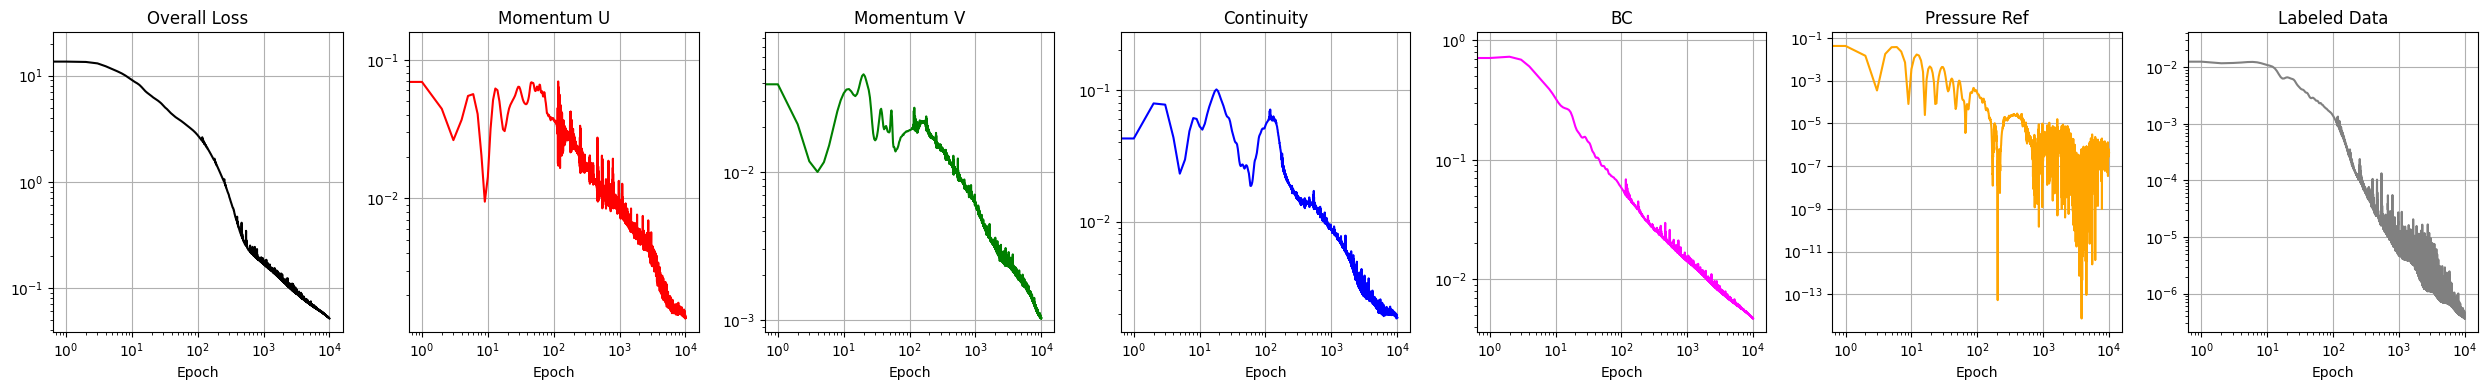

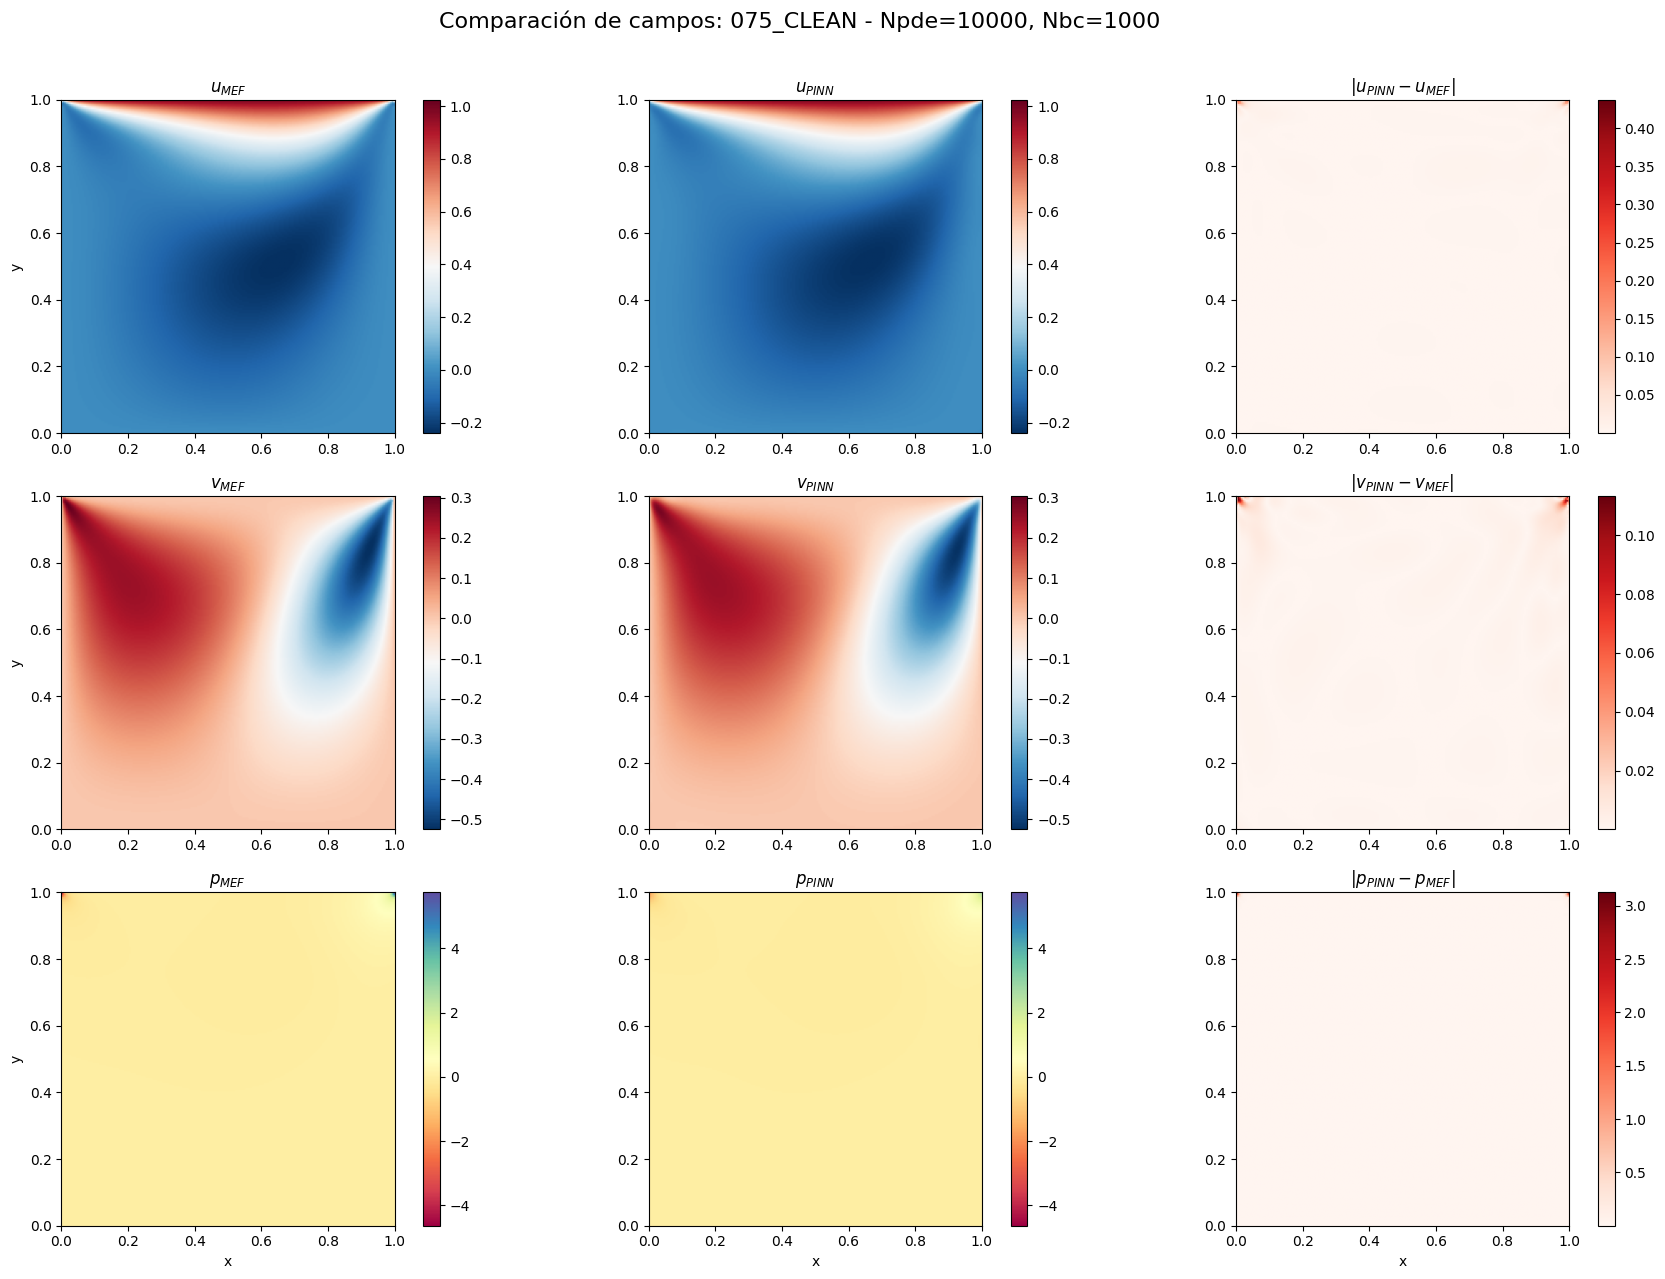

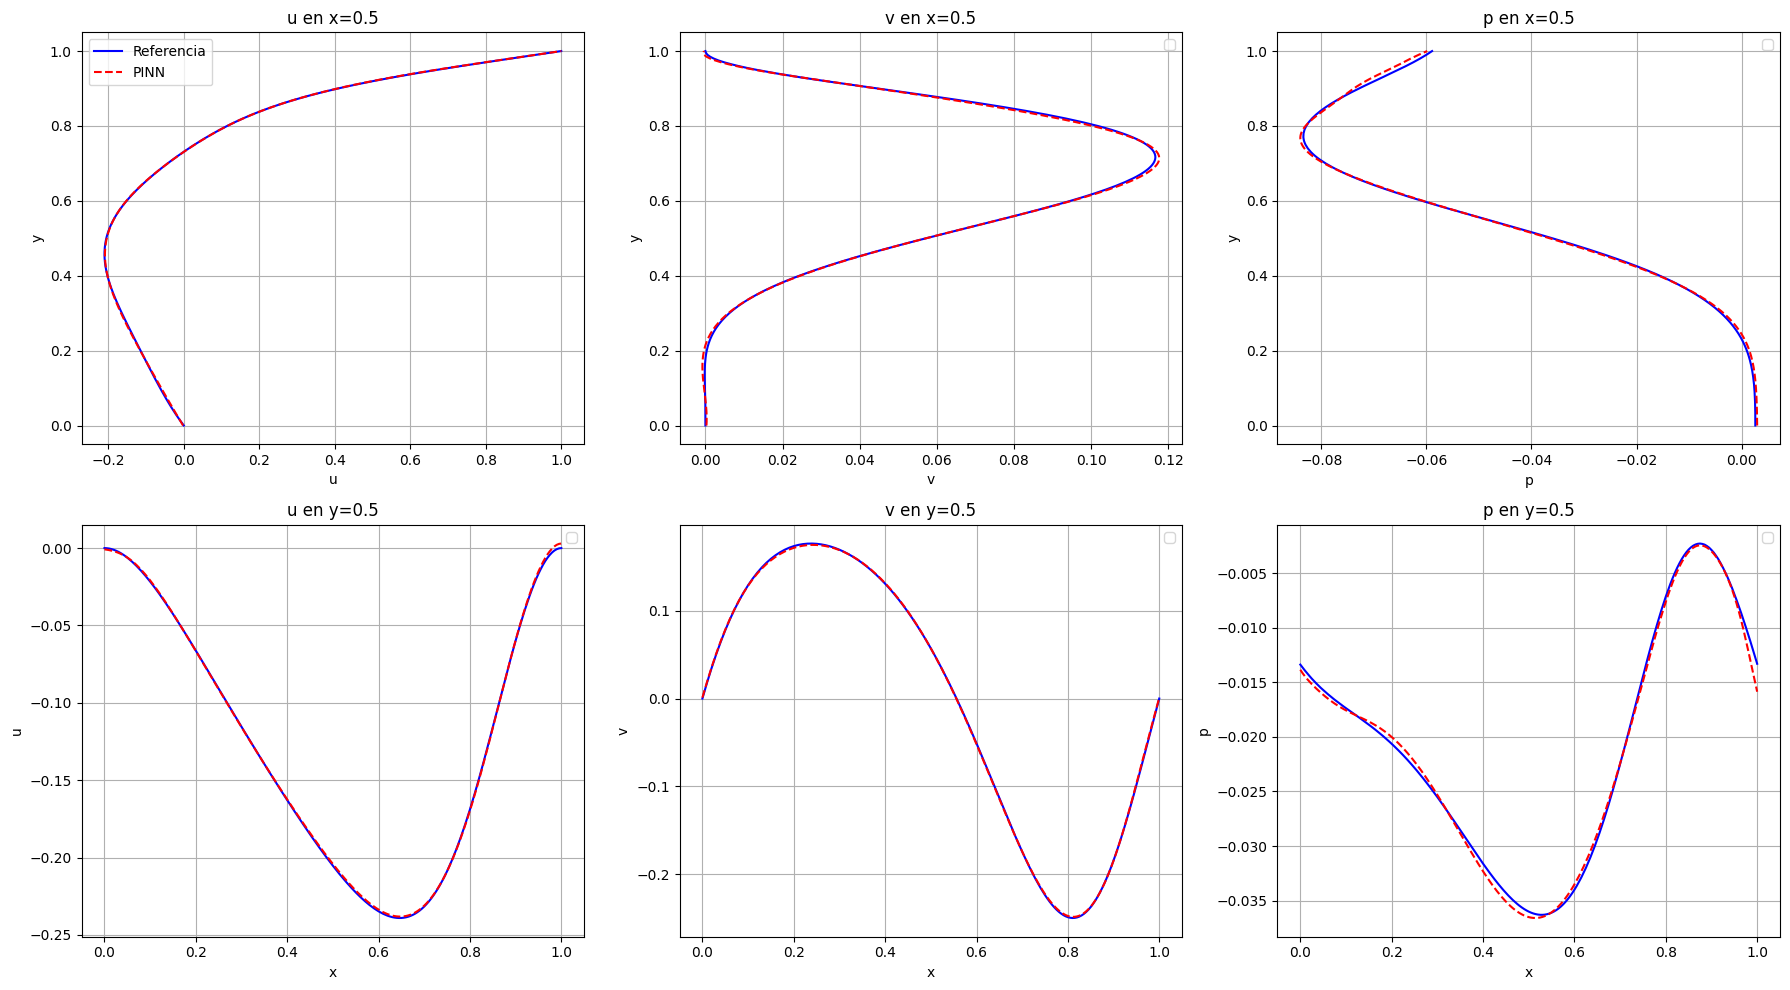


=== Entrenando modelo: 075_noisy ===
Iniciando entrenamiento ...


Entrenando modelo PINN:   0%|          | 4/10000 [00:00<04:20, 38.31it/s]

Epoch    0 | Total: 1.90e+01 | PDE: 4.13e-01 | BC: 8.96e-01 | P_ref: 2.25e-02 | p(0,0): 0.2052 | u_top: 0.232 | Re: 50.09


Entrenando modelo PINN:   5%|▌         | 508/10000 [00:10<03:13, 49.01it/s]

Epoch  500 | Total: 2.75e-01 | PDE: 3.74e-02 | BC: 2.05e-02 | P_ref: 1.03e-05 | p(0,0): 0.0035 | u_top: 0.968 | Re: 94.91


Entrenando modelo PINN:  10%|█         | 1008/10000 [00:21<03:13, 46.48it/s]

Epoch 1000 | Total: 1.66e-01 | PDE: 2.31e-02 | BC: 1.41e-02 | P_ref: 1.04e-06 | p(0,0): 0.0011 | u_top: 0.981 | Re: 100.08


Entrenando modelo PINN:  15%|█▌        | 1509/10000 [00:31<02:52, 49.34it/s]

Epoch 1500 | Total: 1.34e-01 | PDE: 1.64e-02 | BC: 1.16e-02 | P_ref: 1.96e-06 | p(0,0): 0.0014 | u_top: 0.986 | Re: 100.09


Entrenando modelo PINN:  20%|██        | 2009/10000 [00:42<02:52, 46.24it/s]

Epoch 2000 | Total: 1.14e-01 | PDE: 1.32e-02 | BC: 9.98e-03 | P_ref: 1.62e-06 | p(0,0): 0.0012 | u_top: 0.985 | Re: 100.09


Entrenando modelo PINN:  25%|██▌       | 2509/10000 [00:52<02:33, 48.94it/s]

Epoch 2500 | Total: 9.92e-02 | PDE: 1.07e-02 | BC: 8.81e-03 | P_ref: 1.14e-06 | p(0,0): 0.0010 | u_top: 0.988 | Re: 100.08


Entrenando modelo PINN:  30%|███       | 3009/10000 [01:03<02:31, 46.27it/s]

Epoch 3000 | Total: 9.11e-02 | PDE: 9.49e-03 | BC: 8.10e-03 | P_ref: 1.55e-07 | p(0,0): 0.0003 | u_top: 0.983 | Re: 100.07


Entrenando modelo PINN:  35%|███▌      | 3509/10000 [01:13<02:11, 49.29it/s]

Epoch 3500 | Total: 8.34e-02 | PDE: 8.11e-03 | BC: 7.49e-03 | P_ref: 2.57e-10 | p(0,0): -0.0000 | u_top: 0.990 | Re: 100.06


Entrenando modelo PINN:  40%|████      | 4009/10000 [01:23<02:02, 48.85it/s]

Epoch 4000 | Total: 7.84e-02 | PDE: 7.13e-03 | BC: 7.10e-03 | P_ref: 3.24e-09 | p(0,0): 0.0000 | u_top: 0.996 | Re: 100.05


Entrenando modelo PINN:  45%|████▌     | 4509/10000 [01:34<01:53, 48.33it/s]

Epoch 4500 | Total: 7.40e-02 | PDE: 6.47e-03 | BC: 6.72e-03 | P_ref: 4.58e-08 | p(0,0): 0.0005 | u_top: 0.993 | Re: 100.05


Entrenando modelo PINN:  50%|█████     | 5009/10000 [01:44<01:42, 48.52it/s]

Epoch 5000 | Total: 7.04e-02 | PDE: 5.83e-03 | BC: 6.44e-03 | P_ref: 4.16e-07 | p(0,0): 0.0003 | u_top: 0.996 | Re: 100.04


Entrenando modelo PINN:  55%|█████▌    | 5510/10000 [01:55<01:31, 48.81it/s]

Epoch 5500 | Total: 6.75e-02 | PDE: 5.59e-03 | BC: 6.16e-03 | P_ref: 1.84e-07 | p(0,0): 0.0008 | u_top: 0.991 | Re: 100.04


Entrenando modelo PINN:  60%|██████    | 6010/10000 [02:05<01:23, 47.72it/s]

Epoch 6000 | Total: 6.52e-02 | PDE: 5.40e-03 | BC: 5.95e-03 | P_ref: 7.14e-07 | p(0,0): 0.0004 | u_top: 0.993 | Re: 100.03


Entrenando modelo PINN:  65%|██████▌   | 6506/10000 [02:15<01:15, 46.39it/s]

Epoch 6500 | Total: 6.28e-02 | PDE: 5.10e-03 | BC: 5.75e-03 | P_ref: 5.00e-07 | p(0,0): 0.0006 | u_top: 0.994 | Re: 100.03


Entrenando modelo PINN:  70%|███████   | 7006/10000 [02:26<01:04, 46.56it/s]

Epoch 7000 | Total: 6.10e-02 | PDE: 5.05e-03 | BC: 5.58e-03 | P_ref: 7.31e-07 | p(0,0): 0.0006 | u_top: 0.993 | Re: 100.03


Entrenando modelo PINN:  75%|███████▌  | 7506/10000 [02:36<00:54, 45.52it/s]

Epoch 7500 | Total: 5.93e-02 | PDE: 4.94e-03 | BC: 5.42e-03 | P_ref: 5.68e-07 | p(0,0): 0.0007 | u_top: 0.994 | Re: 100.03


Entrenando modelo PINN:  80%|████████  | 8006/10000 [02:47<00:41, 48.13it/s]

Epoch 8000 | Total: 5.75e-02 | PDE: 4.75e-03 | BC: 5.26e-03 | P_ref: 4.37e-07 | p(0,0): 0.0008 | u_top: 0.994 | Re: 100.03


Entrenando modelo PINN:  85%|████████▌ | 8506/10000 [02:58<00:30, 48.41it/s]

Epoch 8500 | Total: 5.60e-02 | PDE: 4.73e-03 | BC: 5.11e-03 | P_ref: 7.18e-07 | p(0,0): 0.0006 | u_top: 0.993 | Re: 100.03


Entrenando modelo PINN:  90%|█████████ | 9006/10000 [03:08<00:21, 45.73it/s]

Epoch 9000 | Total: 5.44e-02 | PDE: 4.53e-03 | BC: 4.97e-03 | P_ref: 4.60e-07 | p(0,0): 0.0007 | u_top: 0.994 | Re: 100.02


Entrenando modelo PINN:  95%|█████████▌| 9506/10000 [03:19<00:10, 48.81it/s]

Epoch 9500 | Total: 5.29e-02 | PDE: 4.38e-03 | BC: 4.84e-03 | P_ref: 5.16e-07 | p(0,0): 0.0006 | u_top: 0.995 | Re: 100.02


Entrenando modelo PINN: 100%|██████████| 10000/10000 [03:29<00:00, 47.64it/s]


Epoch 9999 | Total: 5.15e-02 | PDE: 4.26e-03 | BC: 4.71e-03 | P_ref: 2.58e-07 | p(0,0): 0.0008 | u_top: 0.995 | Re: 100.02

Valor final estimado de Re: 100.0214

Tiempo total: 209.9 segundos
Modelo guardado como: models/pinn_075_noisy_Npde10000_Nbc1000_20250804_002402.pt


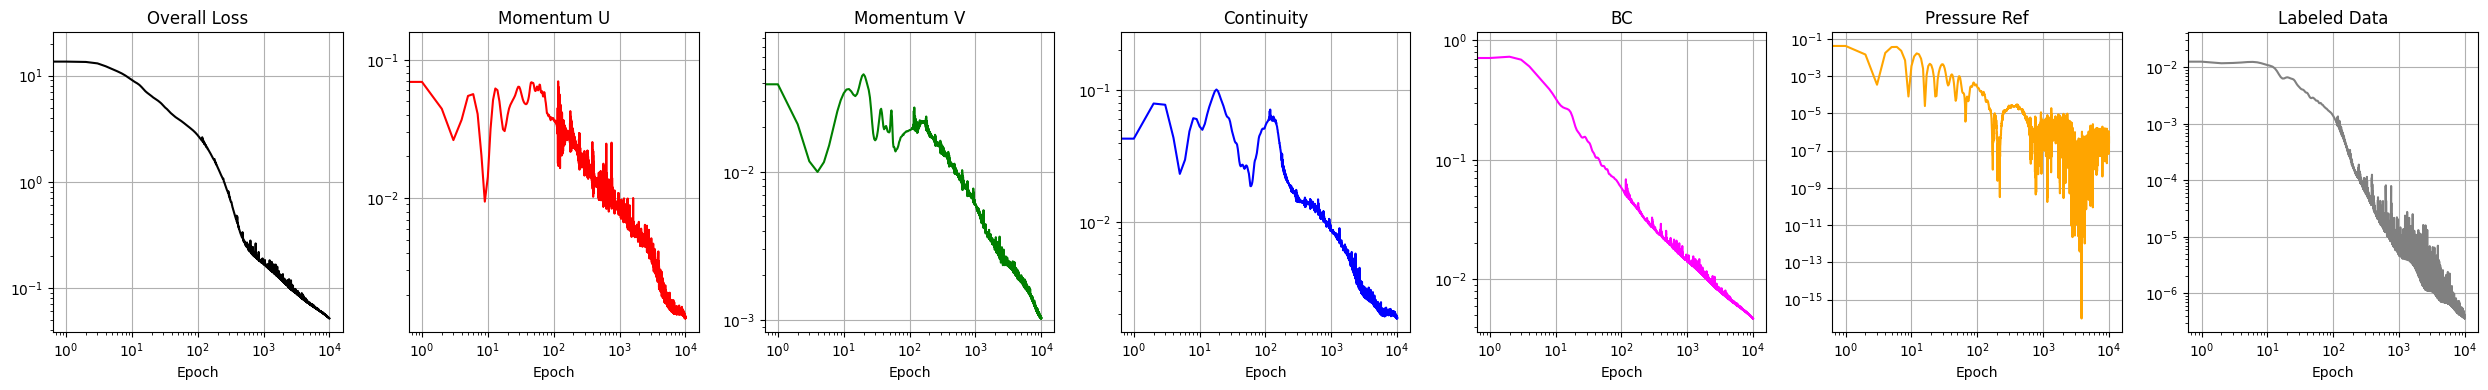

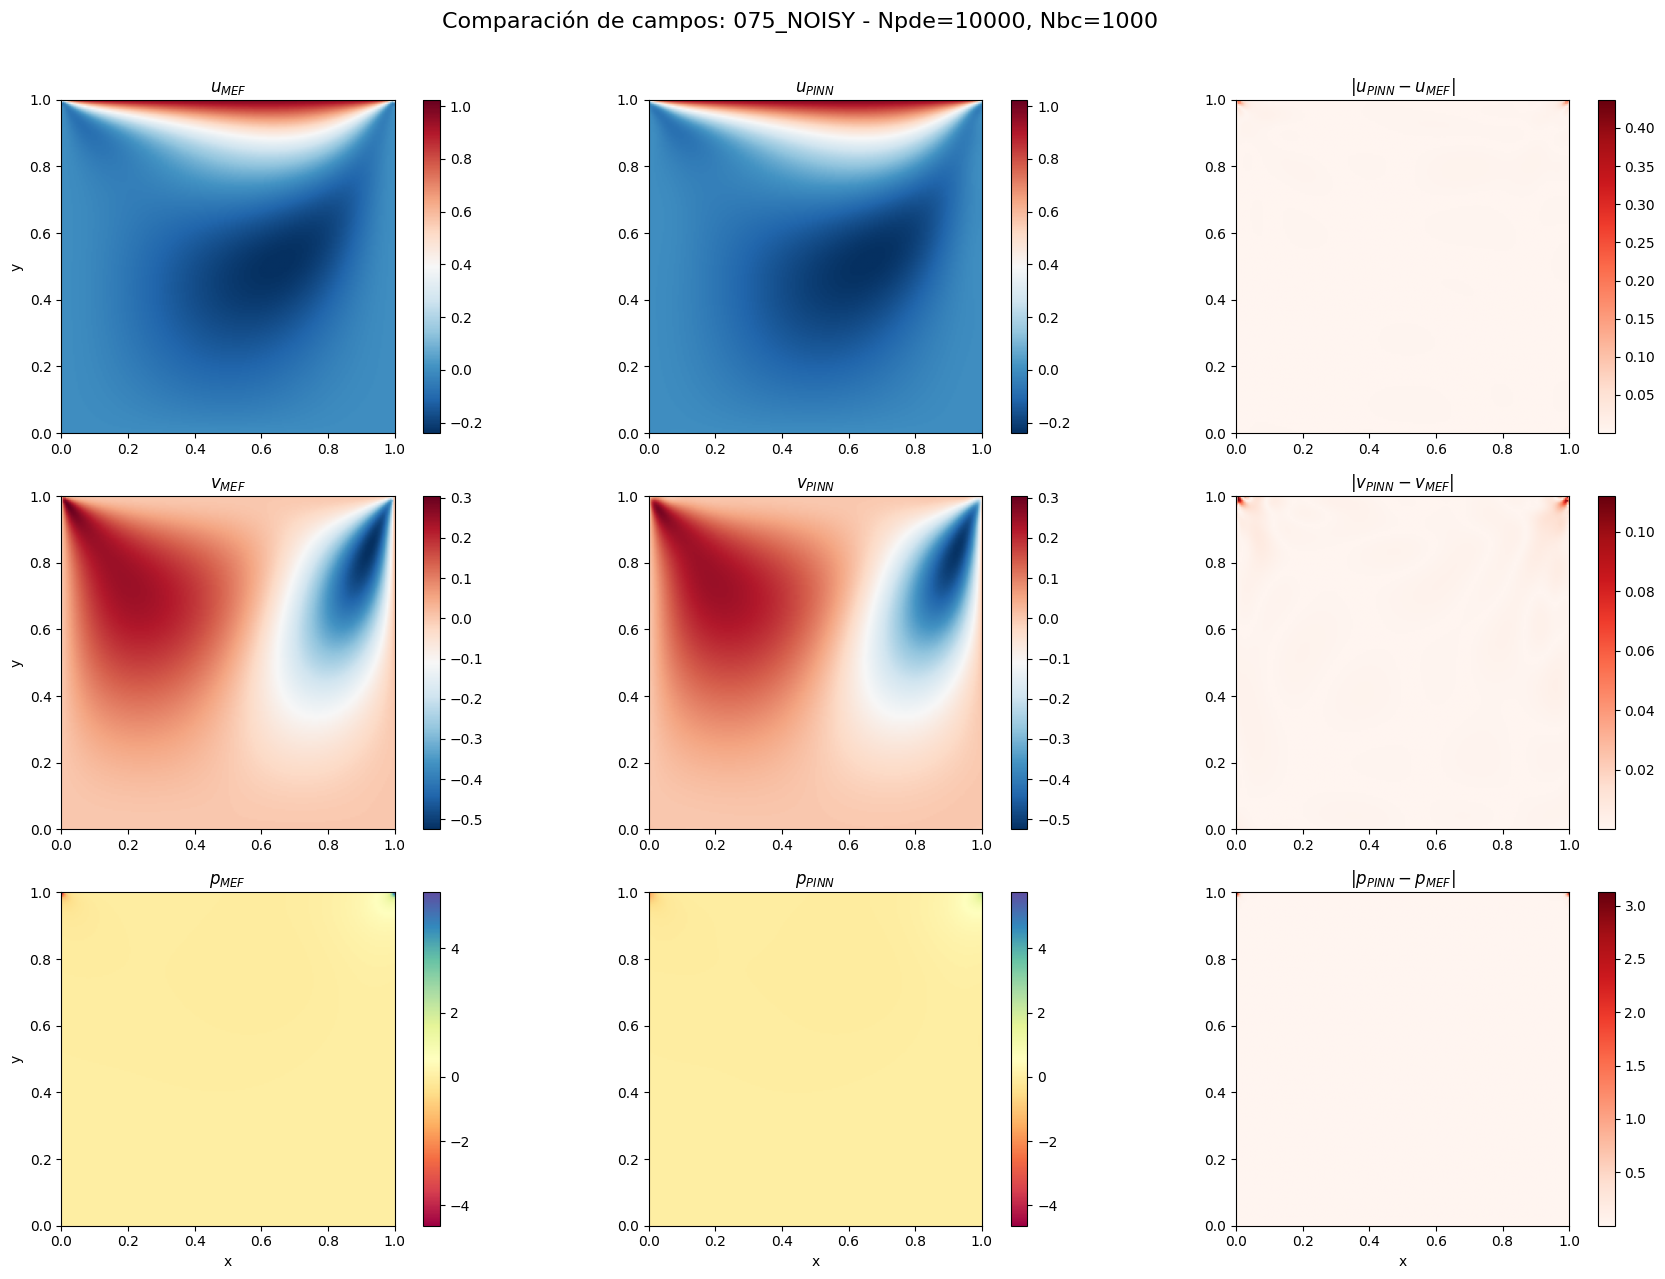

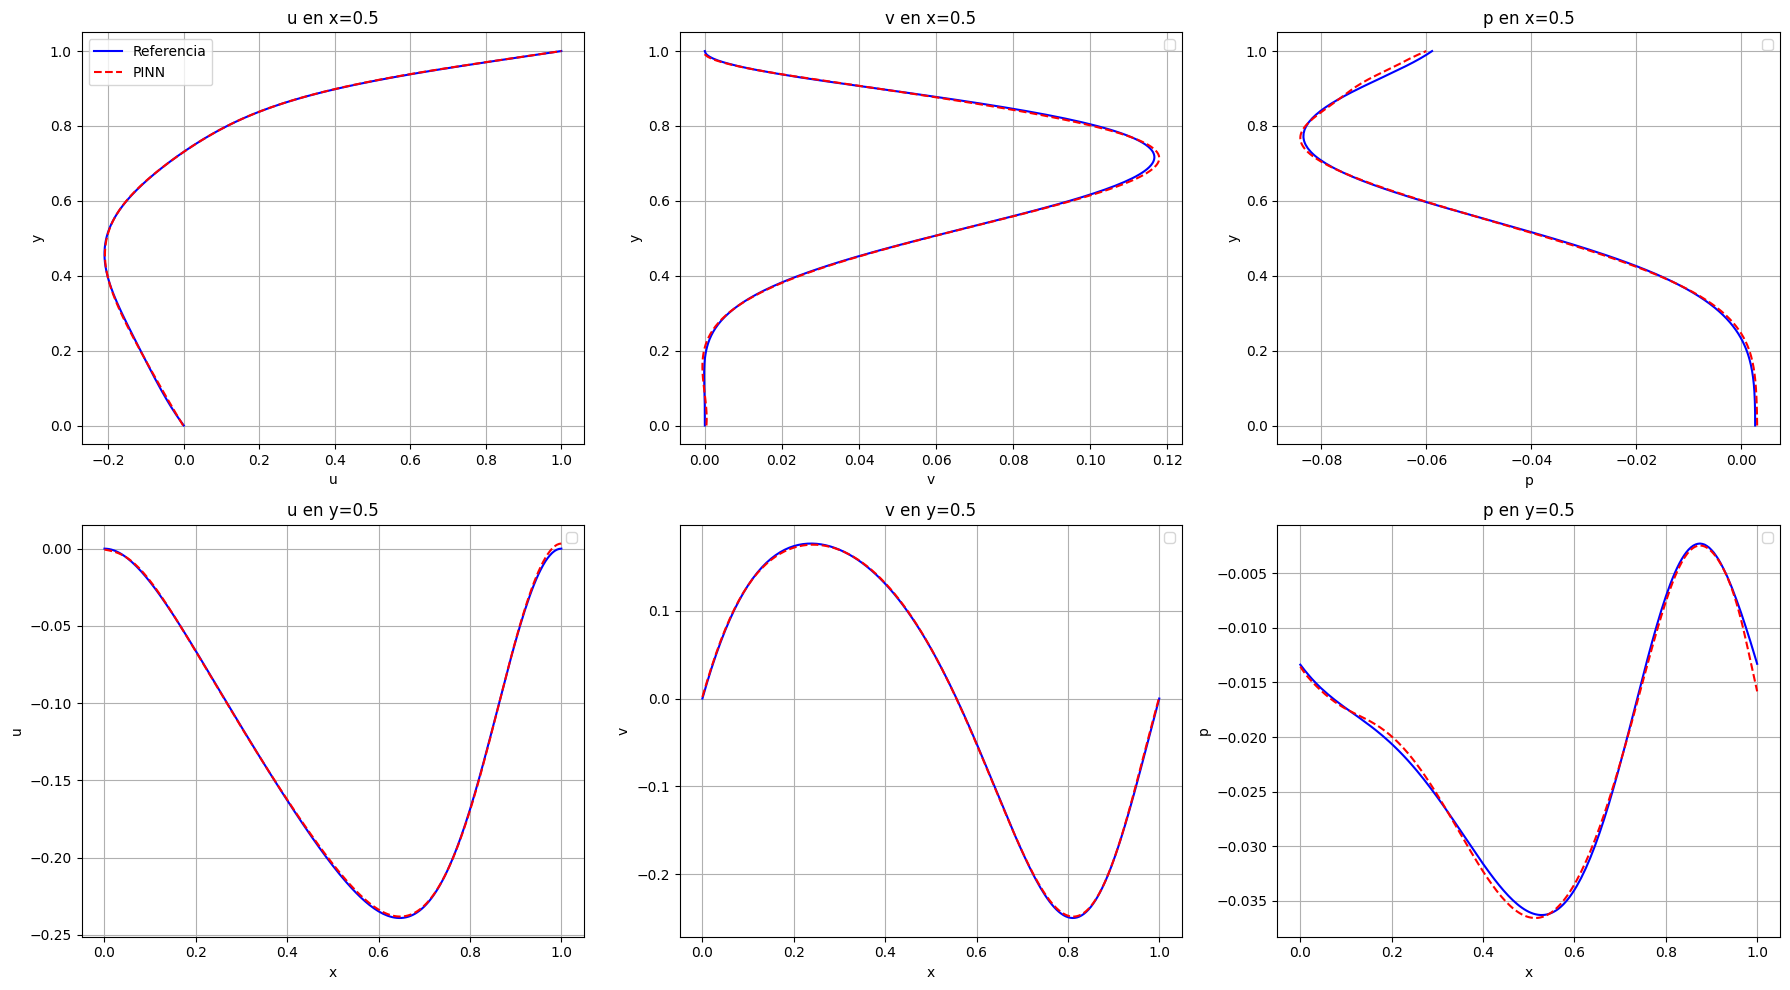

In [20]:
# Grillas y labels
experimentos = [
    ("025_clean", coords_025, labels_025),
    ("025_noisy", coords_025, labels_025_noisy),
    ("050_clean", coords_050, labels_050),
    ("050_noisy", coords_050, labels_050_noisy),
    ("075_clean", coords_075, labels_075),
    ("075_noisy", coords_075, labels_075_noisy),
]

# Resultados
results = {}

# Métricas
re_metrics = {
    "config": [],
    "Re_estimado": [],
    "error_u": [],
    "error_v": [],
    "error_p": [],
}

for config_name, coords_labeled, labels_labeled in experimentos:
    print(f"\n=== Entrenando modelo: {config_name} ===")

    # Reset modelo y optimizador
    model_params = model_parameters.copy()
    model_params["Re"] = 50.0
    model_params["LearnRe"] = True

    torch.manual_seed(10)
    model = PINN_Module(model_params).to(device)

    optimizer = torch.optim.Adam(model.parameters(), lr=0.0017834604711425984, weight_decay=5.291425845841764e-07)
    scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.9996901505905309)

    # Entrenar
    losses = train_pinn(
        model=model,
        pde_points=pde_points,
        top=top, bottom=bottom, left=left, right=right,
        epochs=10000,
        optimizer=optimizer,
        scheduler=scheduler,
        weight_pde=1.0,
        lambda_bc=10.0,
        weight_pressure_ref=1.0,
        coords_labeled=coords_labeled,
        labels_labeled=labels_labeled,
        weight_labeled=300.0,
        weight_re_reg=0.001,  # Pasamos un valor bajo para regularización de Re
        strategy=config_name,
        Npde=N_pde,
        Nbc=N_bc
    )

    # Guardar
    results[config_name] = {
        "model": model,
        "losses": losses
    }

    # Plots
    plot_losses(losses, config_name, N_pde, N_bc)

    # Evaluar
    model.eval()
    with torch.no_grad():
        uvp_pred = model(X_eval)
        u_pred = uvp_pred[:, 0].cpu().numpy().reshape(U_grid.shape)
        v_pred = uvp_pred[:, 1].cpu().numpy().reshape(V_grid.shape)
        p_pred = uvp_pred[:, 2].cpu().numpy().reshape(P_grid.shape)

    # Errores absolutos
    error_u = np.abs(u_pred - U_grid)
    error_v = np.abs(v_pred - V_grid)
    error_p = np.abs(p_pred - P_grid)

    norm2_u = np.linalg.norm(error_u)
    norm2_v = np.linalg.norm(error_v)
    norm2_p = np.linalg.norm(error_p)

    # Guardar métrica
    #Re_estimado = model.Re.item() if isinstance(model.Re, torch.nn.Parameter) else model.Re
    Re_estimado = model.get_re().item()
    re_metrics["config"].append(config_name)
    re_metrics["Re_estimado"].append(Re_estimado)
    re_metrics["error_u"].append(norm2_u)
    re_metrics["error_v"].append(norm2_v)
    re_metrics["error_p"].append(norm2_p)

    # Plots de validación
    plot_comparacion_uvp(u_pred, v_pred, p_pred, config_name, N_pde, N_bc, U_grid, V_grid, P_grid, x, y)
    plot_perfiles_lineas_caracteristicas(u_pred, v_pred, p_pred, U_grid, V_grid, P_grid, X_grid, Y_grid, config_name, N_pde, N_bc)


### 4. Comparar los resultados obtenidos con cada conjunto de datos.

_¿Qué conclusiones pueden extraerse sobre la influencia de la distribución espacial de las muestras en el comportamiento de 𝒖y 𝑝? ¿Y con
respecto a la presencia de ruido?_

In [21]:
df_re_metrics = pd.DataFrame(re_metrics)
display(df_re_metrics)

config  Re_estimado   error_u   error_v   error_p
0  025_clean   100.022942  1.110775  0.759599  6.081080
1  025_noisy   100.022224  1.092276  0.752559  6.094993
2  050_clean   100.012924  1.023061  0.654533  6.078164
3  050_noisy   100.012680  1.037080  0.671885  6.067558
4  075_clean   100.021370  0.993779  0.581010  6.081663
5  075_noisy   100.021416  0.991349  0.589111  6.078891

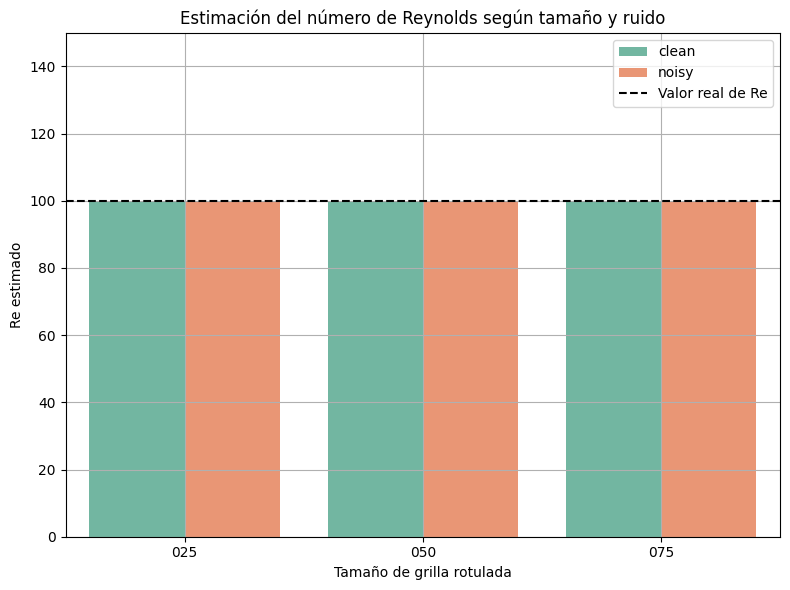

In [22]:
df_re_metrics["tamano"] = df_re_metrics["config"].apply(lambda x: x.split("_")[0])
df_re_metrics["ruido"] = df_re_metrics["config"].apply(lambda x: x.split("_")[1])

plt.figure(figsize=(8, 6))
sns.barplot(data=df_re_metrics, x="tamano", y="Re_estimado", hue="ruido", palette="Set2")

plt.axhline(100.0, linestyle='--', color='black', label="Valor real de Re")
plt.title("Estimación del número de Reynolds según tamaño y ruido")
plt.ylabel("Re estimado")
plt.xlabel("Tamaño de grilla rotulada")
plt.ylim(0, 150)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig(f"{graficas_dir}/re_estimado_barplot.png")
plt.show()

En cuanto a la influencia de la distribucion espacial de las muestras, podemos observar que a medida que se incrementa la densidad de datos rotulados (de 0.25×0.25 a 0.75×0.75), se observa una disminución consistente de los errores, tanto para las velocidades como para la presión. Esto sugiere que una mejor cobertura espacial de los datos rotulados permite al modelo ajustar más finamente la solución, especialmente en regiones donde los gradientes son significativos.

Si analizamos la influencia del ruido, se observa que este apenas afecta el rendimiento del modelo, ya que la estimación de el número de Reynolds se mantiene practicamente inalterada y los errores aumentan de forma marginal. Esto nos indica que el modelo es robusto a la baja magnitud en los datos rotulados, creemos que probablemente gracias a la regularización con la pérdida de PDEs y condiciones de borde y posiblemente el uso de funciones de activación suaves como GELU.